# Mahnob Evaluation

Using leave one subject out, evaluate EEG-only spectral power and topo-based features.

In [1]:
import sys
sys.path.insert(0, "../")

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import os, pickle
from tqdm import tqdm

from libs.dataloaders import mahnob
import xml.etree.ElementTree as ET

from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler

from sklearn.preprocessing import normalize

Matplotlib created a temporary config/cache directory at /tmp/matplotlib-urffeu8p because the default path (/home/anp054/.config/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


In [3]:
def get_sessions_subjs():
    path = "/net2/expData/affective_eeg/mahnob_dataset/Sessions"
    sessions = os.listdir(path)
    subjs = {}
    scores = {}
    for session in sessions:
        mytree = ET.parse(f'{path}/{session}/session.xml')
        myroot = mytree.getroot()
        if myroot[0].attrib['id'] not in subjs:
            subjs[myroot[0].attrib['id']] = []
        if 'feltVlnc' in myroot.attrib:
            subjs[myroot[0].attrib['id']].append(session)
            scores[session] = int(myroot.attrib['feltVlnc'])
    return subjs, scores
subjects, subject_scores = get_sessions_subjs()

In [4]:
def subject_cv(dataset, subject_sessions:list, models:list, sweep_pc=False):
    """
    Run leave one subject out cross-validation using `model`
    Notes:
        - Does _not_ enforce train data balancing, but sets equal priors (assumes data is roughly balanced)
        - Enforce test data; skip fold when per-label count < 3
    @param dataset - dataset
    @param list[list] subject_sessions - sessions binned by subject for leave one subject out
    @param list models - model to use for training; this should be the class, not the instance
    @param bool sweep_pc - sweep the number of PCs
    """
    n_pc_range = np.arange(1, min(len(dataset), len(dataset[0][0][0])+1)) if sweep_pc else np.array([30,]) # min of S and F if sweep enabled
    accs = np.empty((len(subject_sessions), len(models), len(n_pc_range))) # n_subjects -> n_models -> n_pc
    accs[:] = np.nan
    train_accs = accs.copy()
    evs = np.empty((len(subject_sessions), len(models), len(n_pc_range)))
    evs[:] = np.nan
    
    for n_subject, sessions in enumerate(tqdm(subject_sessions.values())):
        train_data = [dataset[i] for i in range(len(dataset)) if dataset.sessions[i] not in sessions]
        test_data = [dataset[i] for i in range(len(dataset)) if dataset.sessions[i] in sessions]
        
        X_train_vgg = np.array([i[0].flatten() for i in train_data])
        Y_train_vgg = np.squeeze([i[1] for i in train_data])*2-1 # rescale to -1, 1
        X_test_vgg = np.array([i[0].flatten() for i in test_data])
        Y_test_vgg = np.squeeze([i[1] for i in test_data])*2-1 # rescale to -1, 1

        if len(Y_train_vgg) == 0 or len(Y_test_vgg) == 0:
            print("Skipping: Y train or Y test having no values")
            continue
        if len(np.unique(Y_test_vgg, return_counts=True)[-1]) != len(np.unique(Y_train_vgg, return_counts=True)[-1]):
            print("Skipping: num classes not being equivalent in train and test")
            continue

        # This really only works for 2 classes; balance
        u_val, u_count = np.unique(Y_test_vgg, return_counts=True)
        u_count = list(u_count)
        if len(u_count) != 2:
            print("Skipping: class count is not exactly 2")
            continue
        if u_count[0] != u_count[1]:
            # balance the classes to the smaller value
            u_reduce = u_val[u_count.index(max(u_count))]
            u_reduce_count = abs(u_count[0] - u_count[1])
            match_idxs = np.argwhere(Y_test_vgg == u_reduce).squeeze()
            np.random.shuffle(match_idxs)
            remove_idxs = match_idxs[:u_reduce_count]
            keep_idxs = [i for i in range(len(Y_test_vgg)) if i not in remove_idxs]
            X_test_vgg = X_test_vgg[keep_idxs]
            Y_test_vgg = Y_test_vgg[keep_idxs]
        
        if min(np.unique(Y_test_vgg, return_counts=True)[-1]) < 3:
            print("Skipping: fewer than 3 samples per class detected")
            continue

        # Shuffle train
        shuffle = np.arange(X_train_vgg.shape[0])
        np.random.shuffle(shuffle)
        X_train_vgg = X_train_vgg[shuffle]
        Y_train_vgg = Y_train_vgg[shuffle]
        
        for n_model, model in enumerate(models):
            pca = PCA() # compute full pc
            pca.fit(X_train_vgg)
            X_train_pc = pca.transform(X_train_vgg)
            X_test_pc = pca.transform(X_test_vgg)
            ev_idxs = [i for i in (n_pc_range-1) if i < len(X_train_pc)]
            evs[n_subject, n_model, :len(ev_idxs)] = pca.explained_variance_ratio_[ev_idxs]
            for n_npc, npc in enumerate(n_pc_range):
                model_inst = model()
                model_inst.fit(X_train_pc[:,:npc], Y_train_vgg)
                model_train = model_inst.score(X_train_pc[:,:npc], Y_train_vgg)
                model_test = model_inst.score(X_test_pc[:,:npc], Y_test_vgg)
                
                accs[n_subject, n_model, n_npc] = model_test
                train_accs[n_subject, n_model, n_npc] = model_train
    return accs, evs, train_accs

In [5]:
class RandomProjection:
    def __init__(self, n_components, center=0, scale=None):
        self.n_components = n_components
        self._projection_matrix = None
        self._center = center
        self._scale = scale

    def fit(self, data):
        if self._scale is None:
            self._scale = 1 / np.sqrt(data.shape[1])
        self._projection_matrix = np.random.normal(self._center, self._scale, (self.n_components, data.shape[1])).T
    
    def transform(self, data):
        return np.dot(data, self._projection_matrix)
    
    def fit_transform(self, data):
        self.fit(data)
        return self.transform(data)


In [6]:
def subject_cv_rp(dataset_imgs, subject_sessions:list, models:list, n_rp_list:list):
    """
    Run random projection leave one subject out cross-validation using `model`
    Notes:
        - Does _not_ enforce train data balancing, but sets equal priors (assumes data is roughly balanced)
        - Enforce test data; skip fold when per-label count < 3
    @param dataset_imgs - dataset
    @param list[list] subject_sessions - sessions binned by subject for leave one subject out
    @param list models - model to use for training; this should be the class, not the instance
    @param list[int] n_rp_list - random projection evaluation list
    """
    accs = np.empty((len(subject_sessions), len(models), len(n_rp_list))) # n_subjects -> n_models -> n_rp
    accs[:] = np.nan
    train_accs = accs.copy()
    evs = np.empty((len(subject_sessions), len(models), len(n_rp_list)))
    evs[:] = np.nan
    
    for n_subject, sessions in enumerate(tqdm(subject_sessions.values())):
        train_data = [dataset_imgs[i] for i in range(len(dataset_imgs)) if dataset_imgs.sessions[i] not in sessions]
        test_data = [dataset_imgs[i] for i in range(len(dataset_imgs)) if dataset_imgs.sessions[i] in sessions]
        
        X_train_vgg = np.array([i[0].flatten() for i in train_data])
        Y_train_vgg = np.squeeze([i[1] for i in train_data])*2-1 # rescale to -1, 1
        X_test_vgg = np.array([i[0].flatten() for i in test_data])
        Y_test_vgg = np.squeeze([i[1] for i in test_data])*2-1 # rescale to -1, 1

        if len(Y_train_vgg) == 0 or len(Y_test_vgg) == 0:
            print("Skipping: Y train or Y test having no values")
            continue
        if len(np.unique(Y_test_vgg, return_counts=True)[-1]) != len(np.unique(Y_train_vgg, return_counts=True)[-1]):
            print("Skipping: num classes not being equivalent in train and test")
            continue

        # This really only works for 2 classes; balance
        u_val, u_count = np.unique(Y_test_vgg, return_counts=True)
        u_count = list(u_count)
        if len(u_count) != 2:
            print("Skipping: class count is not exactly 2")
            continue
        if u_count[0] != u_count[1]:
            # balance the classes to the smaller value
            u_reduce = u_val[u_count.index(max(u_count))]
            u_reduce_count = abs(u_count[0] - u_count[1])
            match_idxs = np.argwhere(Y_test_vgg == u_reduce).squeeze()
            np.random.shuffle(match_idxs)
            remove_idxs = match_idxs[:u_reduce_count]
            keep_idxs = [i for i in range(len(Y_test_vgg)) if i not in remove_idxs]
            X_test_vgg = X_test_vgg[keep_idxs]
            Y_test_vgg = Y_test_vgg[keep_idxs]
        
        if min(np.unique(Y_test_vgg, return_counts=True)[-1]) < 3:
            print("Skipping: fewer than 3 samples per class detected")
            continue

        # Shuffle train
        shuffle = np.arange(X_train_vgg.shape[0])
        np.random.shuffle(shuffle)
        X_train_vgg = X_train_vgg[shuffle]
        Y_train_vgg = Y_train_vgg[shuffle]

        projection = RandomProjection(n_components=max(n_rp_list))
        X_train_rp = projection.fit_transform(X_train_vgg)
        X_test_rp = projection.transform(X_test_vgg)
        
        for n_model, model in enumerate(models):
            for n_nrp, nrp in enumerate(tqdm(n_rp_list)):
                model_inst = model()
                model_inst.fit(X_train_rp[:,:nrp], Y_train_vgg)
                model_test = model_inst.score(X_test_rp[:,:nrp], Y_test_vgg)
                model_train = model_inst.score(X_train_rp[:,:nrp], Y_train_vgg)

                accs[n_subject, n_model, n_nrp] = model_test
                train_accs[n_subject, n_model, n_nrp] = model_train

    return accs, n_rp_list, train_accs

In [7]:
def subject_cv_rp_pc(dataset_imgs, subject_sessions:list, models:list, sweep_pc:bool, nrp=4096):
    """
    Run random projection leave one subject out cross-validation using PCA(`model`).
    Notes:
        - Does _not_ enforce train data balancing, but sets equal priors (assumes data is roughly balanced)
        - Enforce test data; skip fold when per-label count < 3
    @param dataset_imgs - dataset
    @param list[list] subject_sessions - sessions binned by subject for leave one subject out
    @param list models - model to use for training; this should be the class, not the instance
    @param bool sweep_pc - sweep PC or n_pc-30
    """
    n_pc_range = np.arange(1, min(len(dataset_imgs), nrp)) if sweep_pc else np.array([30,]) # min of S and F if sweep enabled
    accs = np.empty((len(subject_sessions), len(models), len(n_pc_range))) # n_subjects -> n_models -> n_rp
    accs[:] = np.nan
    train_accs = accs.copy()
    evs = np.empty((len(subject_sessions), len(models), len(n_pc_range)))
    evs[:] = np.nan
    
    for n_subject, sessions in enumerate(tqdm(subject_sessions.values())):
        train_data = [dataset_imgs[i] for i in range(len(dataset_imgs)) if dataset_imgs.sessions[i] not in sessions]
        test_data = [dataset_imgs[i] for i in range(len(dataset_imgs)) if dataset_imgs.sessions[i] in sessions]
        
        X_train_vgg = np.array([i[0].flatten() for i in train_data])
        Y_train_vgg = np.squeeze([i[1] for i in train_data])*2-1 # rescale to -1, 1
        X_test_vgg = np.array([i[0].flatten() for i in test_data])
        Y_test_vgg = np.squeeze([i[1] for i in test_data])*2-1 # rescale to -1, 1

        if len(Y_train_vgg) == 0 or len(Y_test_vgg) == 0:
            print("Skipping: Y train or Y test having no values")
            continue
        if len(np.unique(Y_test_vgg, return_counts=True)[-1]) != len(np.unique(Y_train_vgg, return_counts=True)[-1]):
            print("Skipping: num classes not being equivalent in train and test")
            continue

        # This really only works for 2 classes; balance
        u_val, u_count = np.unique(Y_test_vgg, return_counts=True)
        u_count = list(u_count)
        if len(u_count) != 2:
            print("Skipping: class count is not exactly 2")
            continue
        if u_count[0] != u_count[1]:
            # balance the classes to the smaller value
            u_reduce = u_val[u_count.index(max(u_count))]
            u_reduce_count = abs(u_count[0] - u_count[1])
            match_idxs = np.argwhere(Y_test_vgg == u_reduce).squeeze()
            np.random.shuffle(match_idxs)
            remove_idxs = match_idxs[:u_reduce_count]
            keep_idxs = [i for i in range(len(Y_test_vgg)) if i not in remove_idxs]
            X_test_vgg = X_test_vgg[keep_idxs]
            Y_test_vgg = Y_test_vgg[keep_idxs]
        
        if min(np.unique(Y_test_vgg, return_counts=True)[-1]) < 3:
            print("Skipping: fewer than 3 samples per class detected")
            continue

        # Shuffle train
        shuffle = np.arange(X_train_vgg.shape[0])
        np.random.shuffle(shuffle)
        X_train_vgg = X_train_vgg[shuffle]
        Y_train_vgg = Y_train_vgg[shuffle]
        
        projection = RandomProjection(n_components=nrp)
        X_train_rp = projection.fit_transform(X_train_vgg)
        X_test_rp = projection.transform(X_test_vgg)

        for n_model, model in enumerate(models):
            pca = PCA() # compute full pc
            pca.fit(X_train_rp)
            X_train_pc = pca.transform(X_train_rp)
            X_test_pc = pca.transform(X_test_rp)
            ev_idxs = [i for i in (n_pc_range-1) if i < len(X_train_pc)]
            evs[n_subject, n_model, :len(ev_idxs)] = pca.explained_variance_ratio_[ev_idxs]
            for n_npc, npc in tqdm(enumerate(n_pc_range)):
                model_inst = model()
                model_inst.fit(X_train_pc[:,:npc], Y_train_vgg)
                model_test = model_inst.score(X_test_pc[:,:npc], Y_test_vgg)
                model_train = model_inst.score(X_train_pc[:,:npc], Y_train_vgg)

                accs[n_subject, n_model, n_npc] = model_test
                train_accs[n_subject, n_model, n_npc] = model_train

    return accs, evs, train_accs

In [8]:
import torch
import torchvision.models as torchmodels
def vgg16_augment(model):
    model.classifier = torch.nn.Sequential(*list(model.classifier.children())[:-3])
def inception_augment(model):
    model = torch.nn.Sequential(*list(torchmodels.inception_v3(weights="DEFAULT").children())[:-3])

In [9]:
from functools import partial
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.svm import SVC, LinearSVC

lda = partial(LinearDiscriminantAnalysis, priors=[0.5, 0.5])
linear_svm = partial(LinearSVC)
nonlinear_svm = partial(SVC, kernel="rbf")
models = [lda, linear_svm, nonlinear_svm]
reduced_models = [lda, ]

## Average Spectral Power

Here we are looking at the average spectral power of Theta, Alpha, Beta, and Gamma per channel, concatenated together to form the feature vector. The results here are reported for a set of classifiers.

In [7]:
dataset = mahnob.MahnobDataset(
    x_params={
        "feature": "AvgFreqPower", 
        "window": -1,
        "stride": -1
    },
    sessions=None,
    y_mode='bimodal',
    y_keys=['feltVlnc'],
    seed=49,
    balanced=False,
)

100%|██████████| 526/526 [00:23<00:00, 22.07it/s]


INFO: T dimension is not equivalent across all S; reducing to T=1


In [8]:
acc, evs, train_acc = subject_cv(dataset, subjects, models, sweep_pc=True)

  0%|          | 0/29 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, 

Skipping: fewer than 3 samples per class detected
Skipping: Y train or Y test having no values


 24%|██▍       | 7/29 [00:34<01:21,  3.72s/it]/opt/conda/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to co

Skipping: Y train or Y test having no values
Skipping: num classes not being equivalent in train and test
Skipping: fewer than 3 samples per class detected


/opt/conda/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  w

Skipping: fewer than 3 samples per class detected


/opt/conda/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  w

In [9]:
with open("result_avgfreqpwr.pkl", "wb") as fout:
    pickle.dump({"acc": acc, 
                 "train_acc": train_acc,
                 "ev": evs, "models": models}, fout)

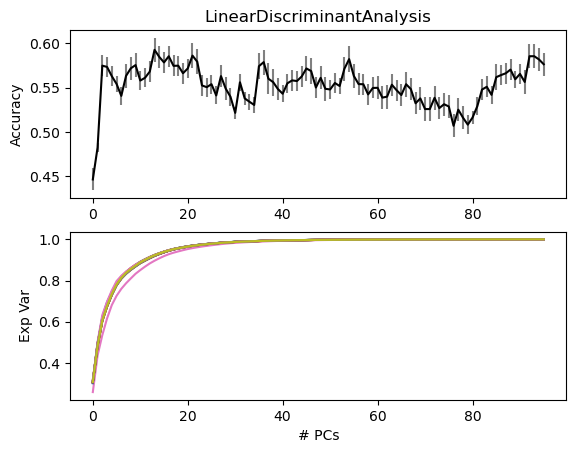

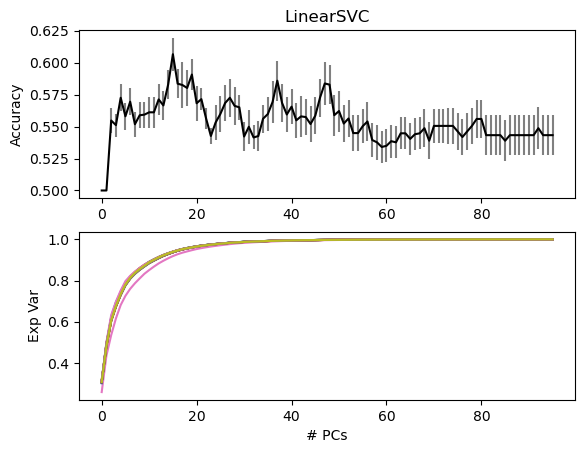

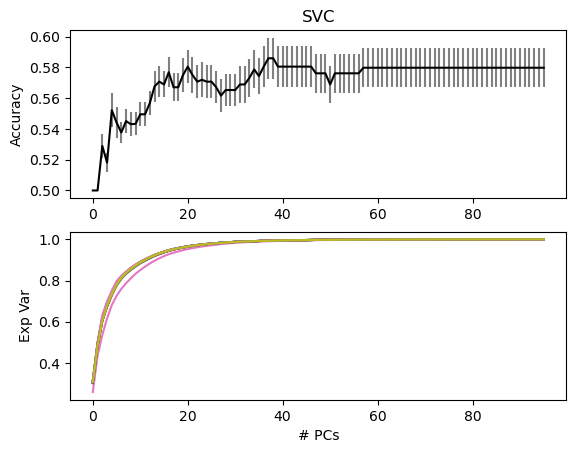

In [10]:
for n_model, model in enumerate(models):
    mdl_acc = acc[:,n_model,:]
    mdl_means = np.nanmean(mdl_acc, axis=0)
    mdl_stderr = np.nanstd(mdl_acc, axis=0) / np.sqrt(len(mdl_means))
    
    plt.subplot(2,1,1)
    plt.errorbar(np.arange(len(mdl_means)), mdl_means, yerr=mdl_stderr, color='k', ecolor="grey")
    plt.title(f"{str(model.func).split('.')[-1][:-2]}")
    plt.ylabel("Accuracy")
    
    plt.subplot(2,1,2)
    plt.plot(np.cumsum(evs[:,n_model,:], axis=-1).T)
    plt.xlabel("# PCs")
    plt.ylabel("Exp Var")
    plt.show()

## High Density Spectral Power

In [11]:
dataset = mahnob.MahnobDataset(
    x_params={
        "feature": "AvgFreqPowerHighDensity", 
        "window": -1,
        "stride": -1
    },
    sessions=None,
    y_mode='bimodal',
    y_keys=['feltVlnc'],
    seed=49,
    balanced=False,
)

100%|██████████| 526/526 [00:00<00:00, 831.03it/s]

INFO: T dimension is not equivalent across all S; reducing to T=1


In [12]:
acc_hd, evs_hd, train_acc_hd = subject_cv(dataset, subjects, reduced_models, sweep_pc=True)

 14%|█▍        | 4/29 [00:36<03:46,  9.07s/it]

Skipping: fewer than 3 samples per class detected
Skipping: Y train or Y test having no values


 28%|██▊       | 8/29 [00:54<02:09,  6.18s/it]

Skipping: Y train or Y test having no values
Skipping: num classes not being equivalent in train and test
Skipping: fewer than 3 samples per class detected


 76%|███████▌  | 22/29 [02:34<01:00,  8.71s/it]

Skipping: fewer than 3 samples per class detected


100%|██████████| 29/29 [03:28<00:00,  7.20s/it]


In [13]:
with open("result_avgfreqpwrhd.pkl", "wb") as fout:
    pickle.dump({"acc": acc_hd, 
                 "train_acc": train_acc_hd,
                 "ev": evs_hd, "models": reduced_models}, fout)

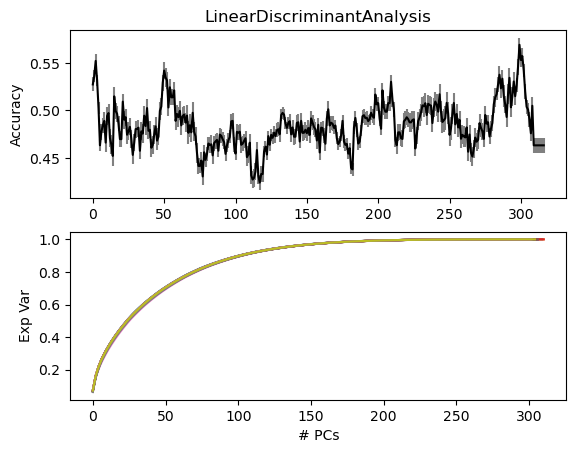

In [14]:
for n_model, model in enumerate(reduced_models):
    mdl_acc = acc_hd[:,n_model,:]
    mdl_means = np.nanmean(mdl_acc, axis=0)
    mdl_stderr = np.nanstd(mdl_acc, axis=0) / np.sqrt(len(mdl_means))
    
    plt.subplot(2,1,1)
    plt.errorbar(np.arange(len(mdl_means)), mdl_means, yerr=mdl_stderr, color='k', ecolor="grey")
    plt.title(f"{str(model.func).split('.')[-1][:-2]}")
    plt.ylabel("Accuracy")
    
    plt.subplot(2,1,2)
    plt.plot(np.cumsum(evs_hd[:,n_model,:], axis=-1).T)
    plt.xlabel("# PCs")
    plt.ylabel("Exp Var")
    plt.show()

## Spectrogram Image Feature - VGG16

In [10]:
dataset = mahnob.MahnobDataset(
    data_dir='/net2/derData/affective_eeg/eeg/raw_asr_mat',
    x_params={
        "feature": "Spectrogram", 
        "model": "vgg16",
        "model_params": {
            "weights": "DEFAULT",
        },
        "model_augment_fn": vgg16_augment,
        "window": -1,
        "stride": -1
    },
    n_sessions=None,
    y_mode='bimodal',
    y_keys=['feltVlnc'],
    seed=49,
    balanced=False,
)

  1%|          | 3/334 [00:00<00:15, 20.76it/s]

  3%|▎         | 10/334 [00:00<00:13, 24.38it/s]

  5%|▍         | 16/334 [00:00<00:13, 23.59it/s]

  6%|▌         | 19/334 [00:00<00:13, 22.74it/s]

  7%|▋         | 25/334 [00:01<00:13, 23.49it/s]

  9%|▉         | 31/334 [00:01<00:13, 22.47it/s]

 10%|█         | 34/334 [00:01<00:13, 22.18it/s]

 12%|█▏        | 40/334 [00:01<00:13, 22.47it/s]

 14%|█▍        | 46/334 [00:02<00:13, 21.77it/s]

 15%|█▍        | 49/334 [00:02<00:13, 21.20it/s]

 16%|█▋        | 55/334 [00:02<00:13, 21.05it/s]

 18%|█▊        | 61/334 [00:02<00:11, 23.11it/s]

 19%|█▉        | 64/334 [00:02<00:11, 22.67it/s]

 21%|██        | 70/334 [00:03<00:11, 23.08it/s]

 23%|██▎       | 76/334 [00:03<00:10, 24.60it/s]

 25%|██▍       | 82/334 [00:03<00:10, 23.02it/s]

 25%|██▌       | 85/334 [00:03<00:11, 22.48it/s]

 27%|██▋       | 91/334 [00:04<00:10, 22.54it/s]

 29%|██▉       | 98/334 [00:04<00:09, 24.82it/s]

 30%|███       | 101/334 [00:04<00:09, 24.08it/s]

 32%|███▏      | 107/334 [00:04<00:09, 23.53it/s]

 34%|███▍      | 113/334 [00:04<00:10, 21.69it/s]

 36%|███▌      | 119/334 [00:05<00:09, 23.34it/s]

 37%|███▋      | 125/334 [00:05<00:08, 23.83it/s]

 38%|███▊      | 128/334 [00:05<00:08, 24.32it/s]

 40%|████      | 134/334 [00:05<00:08, 22.27it/s]

 42%|████▏     | 140/334 [00:06<00:08, 21.85it/s]

 43%|████▎     | 143/334 [00:06<00:08, 22.07it/s]

 45%|████▍     | 149/334 [00:06<00:07, 23.31it/s]

 46%|████▋     | 155/334 [00:06<00:07, 22.74it/s]

 47%|████▋     | 158/334 [00:06<00:07, 22.47it/s]

 49%|████▉     | 164/334 [00:07<00:07, 23.49it/s]

 51%|█████     | 170/334 [00:07<00:07, 22.76it/s]

 52%|█████▏    | 173/334 [00:07<00:07, 22.83it/s]

 54%|█████▎    | 179/334 [00:07<00:06, 23.03it/s]

 55%|█████▌    | 185/334 [00:08<00:06, 22.95it/s]

 56%|█████▋    | 188/334 [00:08<00:06, 22.82it/s]

 58%|█████▊    | 195/334 [00:08<00:05, 24.99it/s]

 60%|██████    | 201/334 [00:08<00:05, 24.03it/s]

 62%|██████▏   | 207/334 [00:09<00:05, 22.39it/s]

 63%|██████▎   | 210/334 [00:09<00:05, 22.41it/s]

 65%|██████▍   | 216/334 [00:09<00:05, 21.74it/s]

 66%|██████▋   | 222/334 [00:09<00:04, 23.83it/s]

 68%|██████▊   | 228/334 [00:09<00:04, 22.19it/s]

 69%|██████▉   | 232/334 [00:10<00:04, 23.85it/s]

 71%|███████▏  | 238/334 [00:10<00:04, 23.32it/s]

 72%|███████▏  | 241/334 [00:10<00:04, 22.86it/s]

 74%|███████▍  | 247/334 [00:10<00:03, 22.69it/s]

 76%|███████▌  | 253/334 [00:11<00:03, 21.79it/s]

 77%|███████▋  | 256/334 [00:11<00:03, 22.21it/s]

 78%|███████▊  | 262/334 [00:11<00:03, 23.36it/s]

 80%|████████  | 268/334 [00:11<00:02, 22.69it/s]

 81%|████████  | 271/334 [00:11<00:02, 22.48it/s]

 83%|████████▎ | 277/334 [00:12<00:02, 23.39it/s]

 85%|████████▍ | 283/334 [00:12<00:02, 22.84it/s]

 86%|████████▌ | 286/334 [00:12<00:02, 21.94it/s]

 87%|████████▋ | 292/334 [00:12<00:01, 22.85it/s]

 89%|████████▉ | 298/334 [00:12<00:01, 24.05it/s]

 91%|█████████ | 304/334 [00:13<00:01, 23.60it/s]

 92%|█████████▏| 307/334 [00:13<00:01, 23.11it/s]

 94%|█████████▎| 313/334 [00:13<00:00, 22.70it/s]

 96%|█████████▌| 319/334 [00:13<00:00, 22.76it/s]

 96%|█████████▋| 322/334 [00:14<00:00, 23.10it/s]

 98%|█████████▊| 328/334 [00:14<00:00, 21.99it/s]

100%|██████████| 334/334 [00:14<00:00, 22.92it/s]


  0%|          | 0/334 [00:00<?, ?it/s][Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  14 tasks      | elapsed:    1.6s
[Parallel(n_jobs=4)]: Done  32 out of  32 | elapsed:    2.3s finished
  0%|          | 1/334 [00:04<27:30,  4.96s/it][Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    1.1s
[Parallel(n_jobs=4)]: Done  32 out of  32 | elapsed:    1.3s finished
  1%|          | 2/334 [00:08<21:17,  3.85s/it][Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    1.1s
[Parallel(n_jobs=4)]: Done  32 out of  32 | elapsed:    1.3s finished
  1%|          | 3/334 [00:11<19:24,  3.52s/it][Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    0.9s
[Parallel(n_jobs=4)]: Done  32 out of  32 | elapsed:    1.1s fini

In [11]:
acc_specto_vgg, evs_specto_vgg, train_acc_specto_vgg = subject_cv(dataset, subjects, reduced_models, sweep_pc=True)

 14%|█▍        | 4/29 [00:26<02:46,  6.65s/it]

Skipping: fewer than 3 samples per class detected
Skipping: Y train or Y test having no values


 38%|███▊      | 11/29 [00:40<00:41,  2.30s/it]

Skipping: Y train or Y test having no values
Skipping: num classes not being equivalent in train and test
Skipping: fewer than 3 samples per class detected


 90%|████████▉ | 26/29 [01:40<00:04,  1.55s/it]

Skipping: Y train or Y test having no values
Skipping: Y train or Y test having no values
Skipping: Y train or Y test having no values
Skipping: Y train or Y test having no values
Skipping: Y train or Y test having no values
Skipping: Y train or Y test having no values


100%|██████████| 29/29 [01:40<00:00,  3.48s/it]

Skipping: Y train or Y test having no values
Skipping: Y train or Y test having no values
Skipping: Y train or Y test having no values


In [12]:
with open("result_specto_vgg16.pkl", "wb") as fout:
    pickle.dump({"acc": acc_specto_vgg, 
                 "train_acc": train_acc_specto_vgg, 
                 "ev": evs_specto_vgg, "models": reduced_models}, fout)

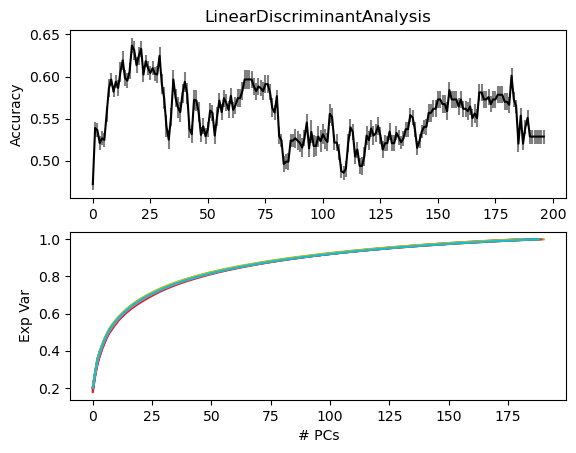

In [13]:
for n_model, model in enumerate(reduced_models):
    mdl_acc = acc_specto_vgg[:,n_model,:]
    mdl_means = np.nanmean(mdl_acc, axis=0)
    mdl_stderr = np.nanstd(mdl_acc, axis=0) / np.sqrt(len(mdl_means))
    
    plt.subplot(2,1,1)
    plt.errorbar(np.arange(len(mdl_means)), mdl_means, yerr=mdl_stderr, color='k', ecolor="grey")
    plt.title(f"{str(model.func).split('.')[-1][:-2]}")
    plt.ylabel("Accuracy")
    
    plt.subplot(2,1,2)
    plt.plot(np.cumsum(evs_specto_vgg[:,n_model,:], axis=-1).T)
    plt.xlabel("# PCs")
    plt.ylabel("Exp Var")
    plt.show()

### PCA(RP_4096(Spectogram))

In [14]:
acc_specto_rp_pc, ev_specto_rp_pc, train_acc_specto_rp_pc = \
    subject_cv_rp_pc(dataset, subjects, reduced_models, sweep_pc=True, nrp=4096)

  0%|          | 0/29 [00:00<?, ?it/s]
0it [00:00, ?it/s]
33it [00:00, 323.80it/s]
66it [00:00, 201.72it/s]
89it [00:00, 137.09it/s]
106it [00:00, 112.91it/s]
119it [00:00, 97.68it/s] 
130it [00:01, 86.71it/s]
140it [00:01, 80.29it/s]
149it [00:01, 71.45it/s]
157it [00:01, 61.67it/s]
164it [00:01, 58.77it/s]
170it [00:01, 53.22it/s]
176it [00:02, 51.40it/s]
182it [00:02, 47.89it/s]
187it [00:02, 46.24it/s]
192it [00:02, 44.48it/s]
197it [00:02, 75.01it/s]
  3%|▎         | 1/29 [00:16<07:33, 16.20s/it]
0it [00:00, ?it/s]
34it [00:00, 337.88it/s]
68it [00:00, 198.53it/s]
91it [00:00, 133.00it/s]
108it [00:00, 109.43it/s]
121it [00:01, 94.69it/s] 
132it [00:01, 80.83it/s]
141it [00:01, 73.36it/s]
149it [00:01, 66.72it/s]
156it [00:01, 62.21it/s]
163it [00:01, 59.69it/s]
169it [00:01, 54.16it/s]
175it [00:02, 51.83it/s]
181it [00:02, 48.10it/s]
186it [00:02, 44.59it/s]
191it [00:02, 43.79it/s]
197it [00:02, 73.40it/s]
  7%|▋         | 2/29 [00:32<07:19, 16.29s/it]
0it [00:00, ?it/s]
33it [

Skipping: fewer than 3 samples per class detected
Skipping: Y train or Y test having no values



0it [00:00, ?it/s]
33it [00:00, 325.60it/s]
66it [00:00, 193.29it/s]
89it [00:00, 135.99it/s]
106it [00:00, 111.96it/s]
119it [00:00, 97.77it/s] 
130it [00:01, 86.58it/s]
140it [00:01, 71.13it/s]
148it [00:01, 64.72it/s]
155it [00:01, 61.95it/s]
162it [00:01, 57.06it/s]
168it [00:01, 54.65it/s]
174it [00:02, 47.59it/s]
179it [00:02, 46.72it/s]
184it [00:02, 45.25it/s]
189it [00:02, 44.33it/s]
197it [00:02, 72.65it/s]
 24%|██▍       | 7/29 [01:21<03:29,  9.54s/it]
0it [00:00, ?it/s]
34it [00:00, 337.55it/s]
68it [00:00, 187.35it/s]
91it [00:00, 130.38it/s]
107it [00:00, 107.24it/s]
120it [00:01, 97.82it/s] 
131it [00:01, 85.99it/s]
141it [00:01, 76.57it/s]
149it [00:01, 71.83it/s]
157it [00:01, 64.79it/s]
164it [00:01, 57.31it/s]
170it [00:01, 54.08it/s]
176it [00:02, 49.38it/s]
181it [00:02, 47.01it/s]
186it [00:02, 45.81it/s]
191it [00:02, 44.50it/s]
197it [00:02, 74.22it/s]
 38%|███▊      | 11/29 [01:38<01:41,  5.62s/it]

Skipping: Y train or Y test having no values
Skipping: num classes not being equivalent in train and test
Skipping: fewer than 3 samples per class detected



0it [00:00, ?it/s]
36it [00:00, 355.21it/s]
72it [00:00, 183.33it/s]
95it [00:00, 130.04it/s]
112it [00:00, 108.44it/s]
125it [00:01, 91.28it/s] 
136it [00:01, 77.14it/s]
145it [00:01, 71.94it/s]
153it [00:01, 65.36it/s]
160it [00:01, 61.89it/s]
167it [00:01, 56.74it/s]
173it [00:02, 54.01it/s]
179it [00:02, 50.27it/s]
184it [00:02, 48.18it/s]
189it [00:02, 46.28it/s]
197it [00:02, 74.48it/s]
 38%|███▊      | 11/29 [01:56<01:41,  5.62s/it]
0it [00:00, ?it/s]
29it [00:00, 288.05it/s]
58it [00:00, 234.07it/s]
83it [00:00, 145.72it/s]
101it [00:00, 115.48it/s]
115it [00:00, 100.84it/s]
127it [00:01, 87.57it/s] 
137it [00:01, 78.52it/s]
146it [00:01, 73.31it/s]
154it [00:01, 66.29it/s]
161it [00:01, 62.62it/s]
168it [00:01, 56.68it/s]
174it [00:02, 52.06it/s]
180it [00:02, 45.55it/s]
185it [00:02, 44.83it/s]
190it [00:02, 42.56it/s]
197it [00:02, 74.38it/s]
 45%|████▍     | 13/29 [02:11<02:24,  9.05s/it]
0it [00:00, ?it/s]
32it [00:00, 319.92it/s]
64it [00:00, 208.18it/s]
88it [00:00, 137

Skipping: Y train or Y test having no values
Skipping: Y train or Y test having no values
Skipping: Y train or Y test having no values
Skipping: Y train or Y test having no values
Skipping: Y train or Y test having no values
Skipping: Y train or Y test having no values
Skipping: Y train or Y test having no values


100%|██████████| 29/29 [04:07<00:00,  8.52s/it]

Skipping: Y train or Y test having no values
Skipping: Y train or Y test having no values


In [15]:
with open("result_specto_rp_pc.pkl", "wb") as fout:
    pickle.dump({"acc": acc_specto_rp_pc, 
                 "train_acc": train_acc_specto_rp_pc, 
                 "ev": ev_specto_rp_pc, "models": reduced_models}, fout)

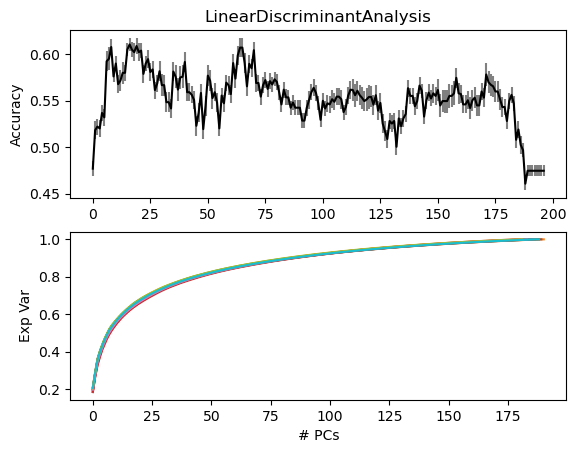

In [16]:
for n_model, model in enumerate(reduced_models):
    mdl_acc = acc_specto_rp_pc[:,n_model,:]
    mdl_means = np.nanmean(mdl_acc, axis=0)
    mdl_stderr = np.nanstd(mdl_acc, axis=0) / np.sqrt(len(mdl_means))
    
    plt.subplot(2,1,1)
    plt.errorbar(np.arange(len(mdl_means)), mdl_means, yerr=mdl_stderr, color='k', ecolor="grey")
    plt.title(f"{str(model.func).split('.')[-1][:-2]}")
    plt.ylabel("Accuracy")
    
    plt.subplot(2,1,2)
    plt.plot(np.cumsum(ev_specto_rp_pc[:,n_model,:], axis=-1).T)
    plt.xlabel("# PCs")
    plt.ylabel("Exp Var")
    plt.show()

## Topo Features

Following methods outlined [here](https://ieeexplore.ieee.org/abstract/document/8713896/), Theta, Alpha, Beta frequency filtered topo images are combined into the three color channels and fed through pretrained image processing model. The performance results are reported as `Feat_Model -> PCA -> Model` and `Feat_model -> Model` as a function of features (ordered by EV for PCA and bootstrapped otherwise).

### VGG16

In [15]:
dataset = mahnob.MahnobDataset(
    x_params={
        "feature": "TopomapNN",
        "model": "vgg16",
        "model_params": {
            "weights": "DEFAULT",
        },
        "model_augment_fn": vgg16_augment,
        "window": -1,
        "stride": -1
    },
    sessions=None,
    y_mode='bimodal',
    y_keys=['feltVlnc'],
    seed=49,
    balanced=False,
)

100%|██████████| 526/526 [01:14<00:00,  7.05it/s]

INFO: T dimension is not equivalent across all S; reducing to T=1


In [16]:
acc_vgg, evs_vgg, train_acc_vgg = subject_cv(dataset, subjects, models, sweep_pc=True)

  0%|          | 0/29 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, 

Skipping: fewer than 3 samples per class detected
Skipping: Y train or Y test having no values


/opt/conda/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  w

Skipping: Y train or Y test having no values
Skipping: num classes not being equivalent in train and test
Skipping: fewer than 3 samples per class detected


/opt/conda/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  w

Skipping: fewer than 3 samples per class detected


/opt/conda/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  w

In [17]:
with open("result_vgg16.pkl", "wb") as fout:
    pickle.dump({"acc": acc_vgg, 
                 "train_acc": train_acc_vgg, 
                 "ev": evs_vgg, "models": models}, fout)

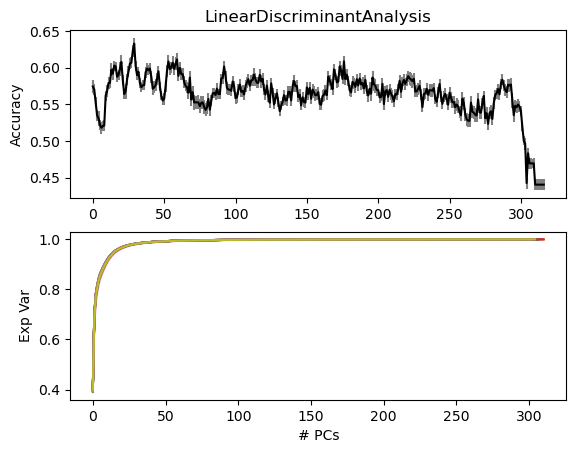

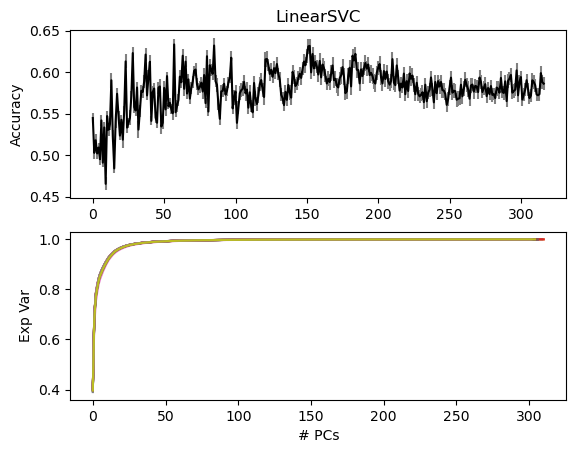

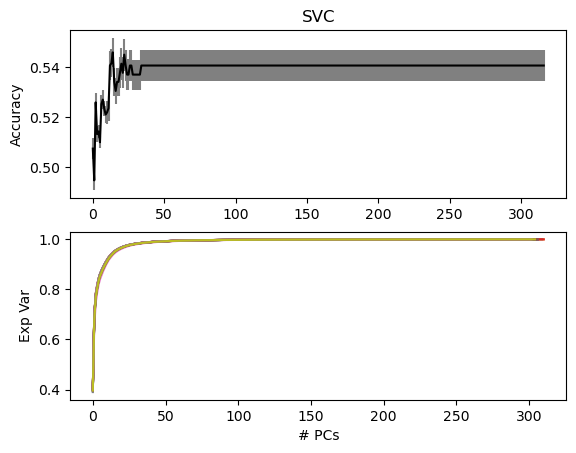

In [18]:
for n_model, model in enumerate(models):
    mdl_acc = acc_vgg[:,n_model,:]
    mdl_means = np.nanmean(mdl_acc, axis=0)
    mdl_stderr = np.nanstd(mdl_acc, axis=0) / np.sqrt(len(mdl_means))
    
    plt.subplot(2,1,1)
    plt.errorbar(np.arange(len(mdl_means)), mdl_means, yerr=mdl_stderr, color='k', ecolor="grey")
    plt.title(f"{str(model.func).split('.')[-1][:-2]}")
    plt.ylabel("Accuracy")
    
    plt.subplot(2,1,2)
    plt.plot(np.cumsum(evs_vgg[:,n_model,:], axis=-1).T)
    plt.xlabel("# PCs")
    plt.ylabel("Exp Var")
    plt.show()

#### Strawman: No PCA
`Feat_Model -> bootstrapped random feature sampling -> Model`

In [19]:
def vgg_cv_strawman(dataset_vgg, subject_sessions:list, models:list, k_bootstrap:int, sweep_div:int):
    """
    Run leave one subject out bootstrap on feature space using `model`. Really should only be used for vgg?
    Notes:
        - Does _not_ enforce train data balancing, but sets equal priors (assumes data is roughly balanced)
        - Enforce test data; skip fold when per-label count < 3
    @param dataset_vgg - dataset
    @param list[list] subject_sessions - sessions binned by subject for leave one subject out
    @param list models - model to use for training; this should be the class, not the instance
    @param int k_bootstrap - number of samplings of each range(1,F-k_bootstrap)
    @param int sweep_div - F to evaluate: range(1,F,sweep_div)
    """
    accs = np.empty((len(subject_sessions), len(models), int(np.ceil((len(dataset_vgg[0][0][0])-1)/sweep_div)))) # n_subjects -> n_models -> F
    accs[:] = np.nan
    train_accs = accs.copy()
    
    for n_subject, sessions in enumerate(tqdm(subject_sessions.values())):
        train_data = [dataset_vgg[i] for i in range(len(dataset_vgg)) if dataset_vgg.sessions[i] not in sessions]
        test_data = [dataset_vgg[i] for i in range(len(dataset_vgg)) if dataset_vgg.sessions[i] in sessions]
        
        X_train_vgg = np.array([i[0].flatten() for i in train_data])
        Y_train_vgg = np.squeeze([i[1] for i in train_data])*2-1 # rescale to -1, 1
        X_test_vgg = np.array([i[0].flatten() for i in test_data])
        Y_test_vgg = np.squeeze([i[1] for i in test_data])*2-1 # rescale to -1, 1

        if len(Y_train_vgg) == 0 or len(Y_test_vgg) == 0:
            print("Skipping: Y train or Y test having no values")
            continue
        if len(np.unique(Y_test_vgg, return_counts=True)[-1]) != len(np.unique(Y_train_vgg, return_counts=True)[-1]):
            print("Skipping: num classes not being equivalent in train and test")
            continue

        # This really only works for 2 classes; balance
        u_val, u_count = np.unique(Y_test_vgg, return_counts=True)
        u_count = list(u_count)
        if len(u_count) != 2:
            print("Skipping: class count is not exactly 2")
            continue
        if u_count[0] != u_count[1]:
            # balance the classes to the smaller value
            u_reduce = u_val[u_count.index(max(u_count))]
            u_reduce_count = abs(u_count[0] - u_count[1])
            match_idxs = np.argwhere(Y_test_vgg == u_reduce).squeeze()
            np.random.shuffle(match_idxs)
            remove_idxs = match_idxs[:u_reduce_count]
            keep_idxs = [i for i in range(len(Y_test_vgg)) if i not in remove_idxs]
            X_test_vgg = X_test_vgg[keep_idxs]
            Y_test_vgg = Y_test_vgg[keep_idxs]
        
        if min(np.unique(Y_test_vgg, return_counts=True)[-1]) < 3:
            print("Skipping: fewer than 3 samples per class detected")
            continue

        # Shuffle train
        shuffle = np.arange(X_train_vgg.shape[0])
        np.random.shuffle(shuffle)
        X_train_vgg = X_train_vgg[shuffle]
        Y_train_vgg = Y_train_vgg[shuffle]
        
        for n_model, model in enumerate(models):
            for f_count in tqdm(range(1, X_train_vgg.shape[-1]+1-k_bootstrap, sweep_div)):
                k_acc = np.zeros(k_bootstrap)
                k_acc_train = np.zeros(k_bootstrap)
                for k in range(k_bootstrap):
                    model_inst = model()
                    f_idx = np.sort(np.random.choice(X_train_vgg.shape[-1], size=f_count, replace=False))
                    model_inst.fit(X_train_vgg[:,f_idx], Y_train_vgg)
                    k_acc[k] = model_inst.score(X_test_vgg[:,f_idx], Y_test_vgg)
                    k_acc_train[k] = model_inst.score(X_train_vgg[:,f_idx], Y_train_vgg)
                accs[n_subject, n_model, int((f_count-1)/sweep_div)] = np.mean(k_acc)
                train_accs[n_subject, n_model, int((f_count-1)/sweep_div)] = np.mean(k_acc_train)
    return accs, train_accs

In [20]:
sweep_div = 100
acc_vgg_strawman, train_acc_vgg_strawman = vgg_cv_strawman(dataset, subjects, reduced_models, k_bootstrap=10, sweep_div=sweep_div)

 14%|█▍        | 4/29 [05:13<32:36, 78.24s/it]

Skipping: fewer than 3 samples per class detected
Skipping: Y train or Y test having no values



 28%|██▊       | 8/29 [07:51<18:37, 53.21s/it]

Skipping: Y train or Y test having no values
Skipping: num classes not being equivalent in train and test
Skipping: fewer than 3 samples per class detected



 76%|███████▌  | 22/29 [22:13<08:48, 75.45s/it]

Skipping: fewer than 3 samples per class detected



100%|██████████| 29/29 [30:05<00:00, 62.24s/it]


In [21]:
with open("result_vgg16_straw_nopca.pkl", "wb") as fout:
    pickle.dump({"acc": acc_vgg_strawman, 
                 "train_acc": train_acc_vgg_strawman,
                 "ev": None, "models": reduced_models}, fout)

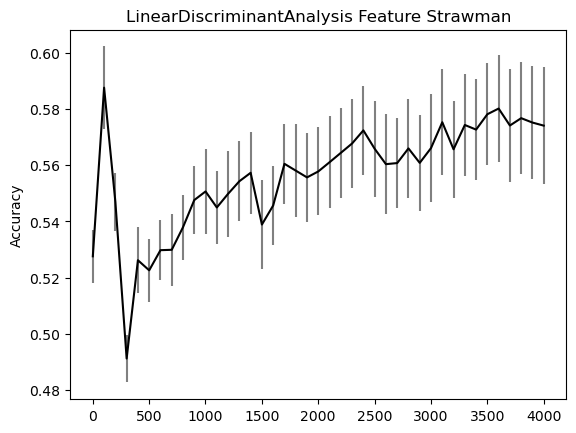

In [22]:
for n_model, model in enumerate(reduced_models):
    mdl_acc = acc_vgg_strawman[:,n_model,:]
    mdl_means = np.nanmean(mdl_acc, axis=0)
    mdl_stderr = np.nanstd(mdl_acc, axis=0) / np.sqrt(len(mdl_means))

    plt.errorbar(np.arange(1,mdl_acc.shape[-1]*sweep_div, sweep_div), mdl_means, yerr=mdl_stderr, color='k', ecolor="grey")
    plt.title(f"{str(model.func).split('.')[-1][:-2]} Feature Strawman")
    plt.ylabel("Accuracy")
    
    plt.show()

#### Strawman: PCA without EV ordering
`Feat_Model -> PC -> bootstrapped random feature sampling -> Model`

In [23]:
def vgg_pc_cv_strawman(dataset_vgg, subject_sessions:list, models:list, k_bootstrap:int):
    """
    Run leave one subject out bootstrap on feature space using `model`. Really should only be used for vgg?
    This is really just a sanity check that PCA isn't adversely impacting transform
    Notes:
        - Does _not_ enforce train data balancing, but sets equal priors (assumes data is roughly balanced)
        - Enforce test data; skip fold when per-label count < 3
    @param dataset_vgg - dataset
    @param list[list] subject_sessions - sessions binned by subject for leave one subject out
    @param list models - model to use for training; this should be the class, not the instance
    @param int k_bootstrap - number of samplings of each range(1,F-k_bootstrap)
    @param int sweep_div - F to evaluate: range(1,F,sweep_div)
    """
    accs = np.empty((len(subject_sessions), len(models), len(dataset_vgg[0][0][0])-1)) # n_subjects -> n_models -> F
    accs[:] = np.nan
    train_accs = accs.copy()
    evs = np.empty(accs.shape)
    evs[:] = np.nan
    
    for n_subject, sessions in enumerate(tqdm(subject_sessions.values())):
        train_data = [dataset_vgg[i] for i in range(len(dataset_vgg)) if dataset_vgg.sessions[i] not in sessions]
        test_data = [dataset_vgg[i] for i in range(len(dataset_vgg)) if dataset_vgg.sessions[i] in sessions]
        
        X_train_vgg = np.array([i[0].flatten() for i in train_data])
        Y_train_vgg = np.squeeze([i[1] for i in train_data])*2-1 # rescale to -1, 1
        X_test_vgg = np.array([i[0].flatten() for i in test_data])
        Y_test_vgg = np.squeeze([i[1] for i in test_data])*2-1 # rescale to -1, 1

        if len(Y_train_vgg) == 0 or len(Y_test_vgg) == 0:
            print("Skipping: Y train or Y test having no values")
            continue
        if len(np.unique(Y_test_vgg, return_counts=True)[-1]) != len(np.unique(Y_train_vgg, return_counts=True)[-1]):
            print("Skipping: num classes not being equivalent in train and test")
            continue

        # This really only works for 2 classes; balance
        u_val, u_count = np.unique(Y_test_vgg, return_counts=True)
        u_count = list(u_count)
        if len(u_count) != 2:
            print("Skipping: class count is not exactly 2")
            continue
        if u_count[0] != u_count[1]:
            # balance the classes to the smaller value
            u_reduce = u_val[u_count.index(max(u_count))]
            u_reduce_count = abs(u_count[0] - u_count[1])
            match_idxs = np.argwhere(Y_test_vgg == u_reduce).squeeze()
            np.random.shuffle(match_idxs)
            remove_idxs = match_idxs[:u_reduce_count]
            keep_idxs = [i for i in range(len(Y_test_vgg)) if i not in remove_idxs]
            X_test_vgg = X_test_vgg[keep_idxs]
            Y_test_vgg = Y_test_vgg[keep_idxs]
        
        if min(np.unique(Y_test_vgg, return_counts=True)[-1]) < 3:
            print("Skipping: fewer than 3 samples per class detected")
            continue

        # Shuffle train
        shuffle = np.arange(X_train_vgg.shape[0])
        np.random.shuffle(shuffle)
        X_train_vgg = X_train_vgg[shuffle]
        Y_train_vgg = Y_train_vgg[shuffle]
        
        for n_model, model in enumerate(models):
            pca = PCA() # compute full pc
            pca.fit(X_train_vgg)
            X_train_pc = pca.transform(X_train_vgg)
            X_test_pc = pca.transform(X_test_vgg)
            f_counts = list(range(1, acc.shape[-1]+1-k_bootstrap))
            evs[n_subject, n_model, f_counts] = pca.explained_variance_ratio_[f_counts]
            for f_count in f_counts:
                k_acc = np.zeros(k_bootstrap)
                train_k_acc = np.zeros(k_bootstrap)
                for k in range(k_bootstrap):
                    model_inst = model()
                    f_idx = np.sort(np.random.choice(X_train_pc.shape[-1], size=f_count, replace=False))
                    model_inst.fit(X_train_pc[:,f_idx], Y_train_vgg)
                    k_acc[k] = model_inst.score(X_test_pc[:,f_idx], Y_test_vgg)
                    train_k_acc[k] = model_inst.score(X_train_pc[:,f_idx], Y_train_vgg)
                accs[n_subject, n_model, f_count-1] = np.mean(k_acc)
                train_accs[n_subject, n_model, f_count-1] = np.mean(train_k_acc)
    return accs, evs, train_accs

In [24]:
acc_pc_vgg_strawman, ev_pc_vgg_strawman, train_acc_pc_vgg_strawman = vgg_pc_cv_strawman(dataset, subjects, reduced_models, k_bootstrap=10)

 14%|█▍        | 4/29 [00:30<03:09,  7.56s/it]

Skipping: fewer than 3 samples per class detected
Skipping: Y train or Y test having no values


 28%|██▊       | 8/29 [00:45<01:47,  5.13s/it]

Skipping: Y train or Y test having no values
Skipping: num classes not being equivalent in train and test
Skipping: fewer than 3 samples per class detected


 76%|███████▌  | 22/29 [02:08<00:50,  7.28s/it]

Skipping: fewer than 3 samples per class detected


100%|██████████| 29/29 [02:53<00:00,  5.98s/it]


In [25]:
with open("result_vgg16_straw_randpca.pkl", "wb") as fout:
    pickle.dump({"acc": acc_pc_vgg_strawman, 
                 "train_acc": train_acc_pc_vgg_strawman, 
                 "ev": ev_pc_vgg_strawman, "models": reduced_models}, fout)

/tmp/ipykernel_24856/1853199955.py:3: RuntimeWarning: Mean of empty slice
  mdl_means = np.nanmean(mdl_acc, axis=0)
/opt/conda/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


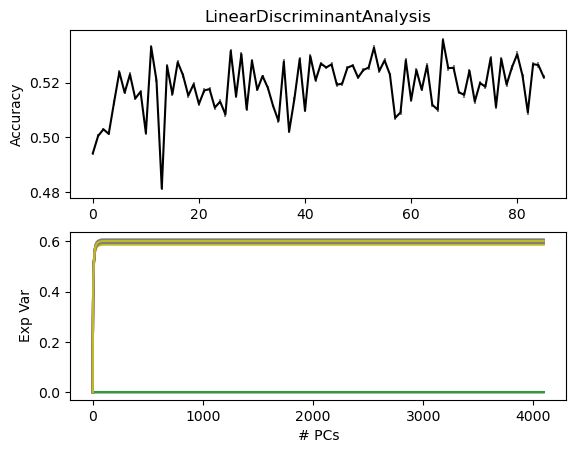

In [26]:
for n_model, model in enumerate(reduced_models):
    mdl_acc = acc_pc_vgg_strawman[:,n_model,:]
    mdl_means = np.nanmean(mdl_acc, axis=0)
    mdl_stderr = np.nanstd(mdl_acc, axis=0) / np.sqrt(len(mdl_means))
    
    plt.subplot(2,1,1)
    plt.errorbar(np.arange(len(mdl_means)), mdl_means, yerr=mdl_stderr, color='k', ecolor="grey")
    plt.title(f"{str(model.func).split('.')[-1][:-2]}")
    plt.ylabel("Accuracy")
    
    plt.subplot(2,1,2)
    plt.plot(np.nancumsum(ev_pc_vgg_strawman[:,n_model,:], axis=-1).T)
    plt.xlabel("# PCs")
    plt.ylabel("Exp Var")
    plt.show()

#### Strawman: Random Initialization
Using the VGG16 model architecture, initialize the weights randomly to measure the impact of architecture versus out-of-distribution trained performance.

In [27]:
dataset = mahnob.MahnobDataset(
    x_params={
        "feature": "TopomapNN",
        "model": "vgg16",
        "model_params": {
            "weights": "DEFAULT",
        },
        "model_augment_fn": vgg16_augment,
        "random_weights": {
            "mode": "rand_init"
        },
        "window": -1,
        "stride": -1
    },
    sessions=None,
    y_mode='bimodal',
    y_keys=['feltVlnc'],
    seed=49,
    balanced=False,
)

100%|██████████| 526/526 [01:14<00:00,  7.03it/s]

INFO: T dimension is not equivalent across all S; reducing to T=1


In [28]:
acc_vgg_randinit, evs_vgg_randinit, train_acc_vgg_randinit = subject_cv(dataset, subjects, reduced_models, sweep_pc=True)

 14%|█▍        | 4/29 [00:39<04:03,  9.76s/it]

Skipping: fewer than 3 samples per class detected
Skipping: Y train or Y test having no values


 28%|██▊       | 8/29 [00:58<02:19,  6.66s/it]

Skipping: Y train or Y test having no values
Skipping: num classes not being equivalent in train and test
Skipping: fewer than 3 samples per class detected


 76%|███████▌  | 22/29 [02:47<01:06,  9.45s/it]

Skipping: fewer than 3 samples per class detected


100%|██████████| 29/29 [03:45<00:00,  7.79s/it]


In [29]:
with open("result_vgg16_straw_randinit.pkl", "wb") as fout:
    pickle.dump({"acc": acc_vgg_randinit, 
                 "train_acc": train_acc_vgg_randinit, 
                 "ev": evs_vgg_randinit, "models": reduced_models}, fout)

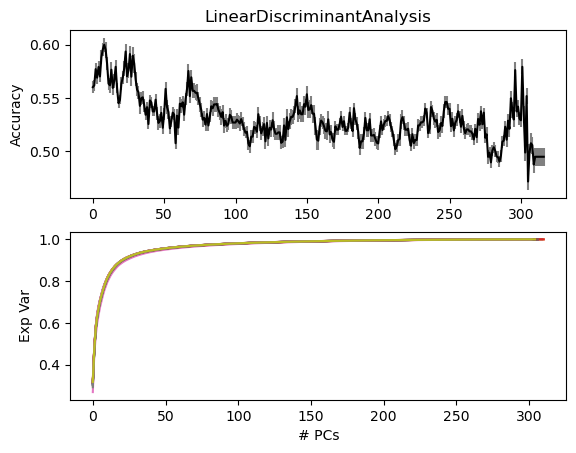

In [30]:
for n_model, model in enumerate(reduced_models):
    mdl_acc = acc_vgg_randinit[:,n_model,:]
    mdl_means = np.nanmean(mdl_acc, axis=0)
    mdl_stderr = np.nanstd(mdl_acc, axis=0) / np.sqrt(len(mdl_means))
    
    plt.subplot(2,1,1)
    plt.errorbar(np.arange(len(mdl_means)), mdl_means, yerr=mdl_stderr, color='k', ecolor="grey")
    plt.title(f"{str(model.func).split('.')[-1][:-2]}")
    plt.ylabel("Accuracy")
    
    plt.subplot(2,1,2)
    plt.plot(np.cumsum(evs_vgg_randinit[:,n_model,:], axis=-1).T)
    plt.xlabel("# PCs")
    plt.ylabel("Exp Var")
    plt.show()

### AlexNet

In [31]:
dataset = mahnob.MahnobDataset(
    x_params={
        "feature": "TopomapNN",
        "model": "alexnet",
        "model_params": {
            "weights": "DEFAULT",
        },
        "model_augment_fn": vgg16_augment, # using same transform for alexnet
        "window": -1,
        "stride": -1
    },
    sessions=None,
    y_mode='bimodal',
    y_keys=['feltVlnc'],
    seed=49,
    balanced=False,
)

100%|██████████| 526/526 [01:13<00:00,  7.17it/s]

INFO: T dimension is not equivalent across all S; reducing to T=1


In [32]:
acc_alexnet, evs_alexnet, train_acc_alexnet = subject_cv(dataset, subjects, models, sweep_pc=True)

  0%|          | 0/29 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, 

Skipping: fewer than 3 samples per class detected
Skipping: Y train or Y test having no values


/opt/conda/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  w

Skipping: Y train or Y test having no values
Skipping: num classes not being equivalent in train and test
Skipping: fewer than 3 samples per class detected


/opt/conda/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  w

Skipping: fewer than 3 samples per class detected


/opt/conda/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  w

In [33]:
with open("result_alexnet.pkl", "wb") as fout:
    pickle.dump({"acc": acc_alexnet, 
                 "train_acc": train_acc_alexnet,
                 "ev": evs_alexnet, "models": models}, fout)

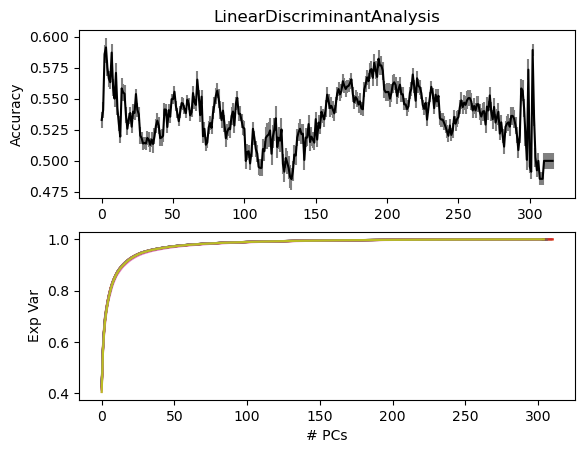

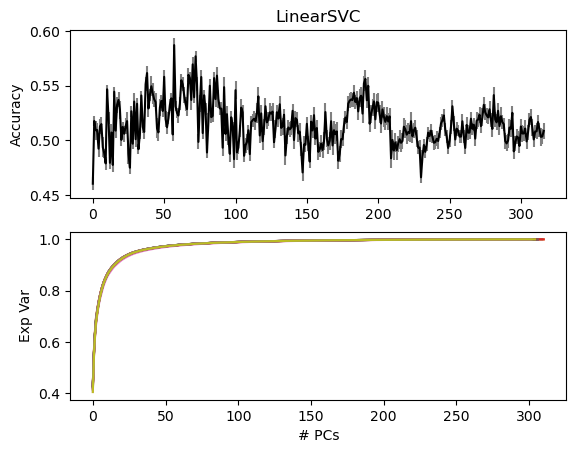

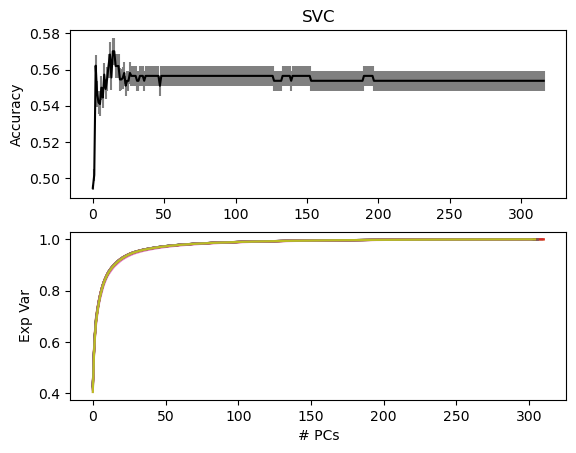

In [34]:
for n_model, model in enumerate(models):
    mdl_acc = acc_alexnet[:,n_model,:]
    mdl_means = np.nanmean(mdl_acc, axis=0)
    mdl_stderr = np.nanstd(mdl_acc, axis=0) / np.sqrt(len(mdl_means))
    
    plt.subplot(2,1,1)
    plt.errorbar(np.arange(len(mdl_means)), mdl_means, yerr=mdl_stderr, color='k', ecolor="grey")
    plt.title(f"{str(model.func).split('.')[-1][:-2]}")
    plt.ylabel("Accuracy")
    
    plt.subplot(2,1,2)
    plt.plot(np.cumsum(evs_alexnet[:,n_model,:], axis=-1).T)
    plt.xlabel("# PCs")
    plt.ylabel("Exp Var")
    plt.show()

#### Strawman: Random Initialization

In [35]:
dataset = mahnob.MahnobDataset(
    x_params={
        "feature": "TopomapNN",
        "model": "alexnet",
        "model_params": {
            "weights": "DEFAULT",
        },
        "model_augment_fn": vgg16_augment, # using same transform for alexnet
        "random_weights": {
            "mode": "rand_init"
        },
        "window": -1,
        "stride": -1
    },
    sessions=None,
    y_mode='bimodal',
    y_keys=['feltVlnc'],
    seed=49,
    balanced=False,
)

100%|██████████| 526/526 [01:13<00:00,  7.17it/s]

INFO: T dimension is not equivalent across all S; reducing to T=1


In [36]:
acc_alexnet_randinit, evs_alexnet_randinit, train_acc_alexnet_randinit = subject_cv(dataset, subjects, reduced_models, sweep_pc=True)

 14%|█▍        | 4/29 [00:38<04:02,  9.69s/it]

Skipping: fewer than 3 samples per class detected
Skipping: Y train or Y test having no values


 28%|██▊       | 8/29 [00:58<02:19,  6.65s/it]

Skipping: Y train or Y test having no values
Skipping: num classes not being equivalent in train and test
Skipping: fewer than 3 samples per class detected


 76%|███████▌  | 22/29 [02:46<01:06,  9.45s/it]

Skipping: fewer than 3 samples per class detected


100%|██████████| 29/29 [03:45<00:00,  7.76s/it]


In [37]:
with open("result_alexnet_straw_randinit.pkl", "wb") as fout:
    pickle.dump({"acc": acc_alexnet_randinit, 
                 "train_acc": train_acc_alexnet_randinit,
                 "ev": evs_alexnet_randinit, "models": reduced_models}, fout)

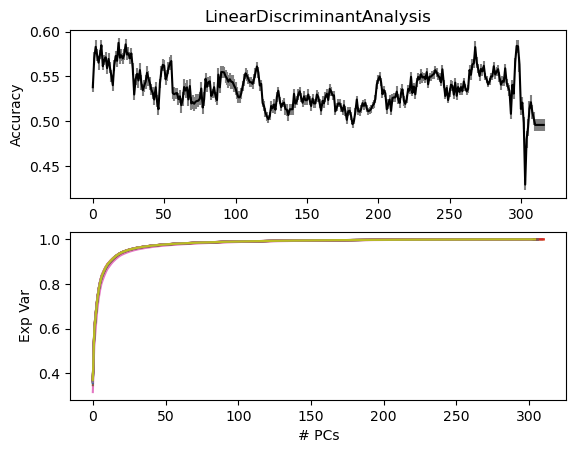

In [38]:
for n_model, model in enumerate(reduced_models):
    mdl_acc = acc_alexnet_randinit[:,n_model,:]
    mdl_means = np.nanmean(mdl_acc, axis=0)
    mdl_stderr = np.nanstd(mdl_acc, axis=0) / np.sqrt(len(mdl_means))
    
    plt.subplot(2,1,1)
    plt.errorbar(np.arange(len(mdl_means)), mdl_means, yerr=mdl_stderr, color='k', ecolor="grey")
    plt.title(f"{str(model.func).split('.')[-1][:-2]}")
    plt.ylabel("Accuracy")
    
    plt.subplot(2,1,2)
    plt.plot(np.cumsum(evs_alexnet_randinit[:,n_model,:], axis=-1).T)
    plt.xlabel("# PCs")
    plt.ylabel("Exp Var")
    plt.show()

### InceptionNet v3

In [39]:
dataset = mahnob.MahnobDataset(
    x_params={
        "feature": "TopomapNN",
        "model": "inception_v3",
        "model_params": {
            "weights": "DEFAULT",
        },
        "model_augment_fn": inception_augment,
        "window": -1,
        "stride": -1
    },
    sessions=None,
    y_mode='bimodal',
    y_keys=['feltVlnc'],
    seed=49,
    balanced=False,
)

100%|██████████| 526/526 [01:20<00:00,  6.53it/s]

INFO: T dimension is not equivalent across all S; reducing to T=1


In [40]:
acc_incepv3, evs_incepv3, train_acc_incepv3 = subject_cv(dataset, subjects, models, sweep_pc=True)

  0%|          | 0/29 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, 

Skipping: fewer than 3 samples per class detected
Skipping: Y train or Y test having no values


/opt/conda/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  w

Skipping: Y train or Y test having no values
Skipping: num classes not being equivalent in train and test
Skipping: fewer than 3 samples per class detected


/opt/conda/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  w

Skipping: fewer than 3 samples per class detected


/opt/conda/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  w

In [41]:
with open("result_incepv3.pkl", "wb") as fout:
    pickle.dump({"acc": acc_incepv3, 
                 "train_acc": train_acc_incepv3,
                 "ev": evs_incepv3, "models": models}, fout)

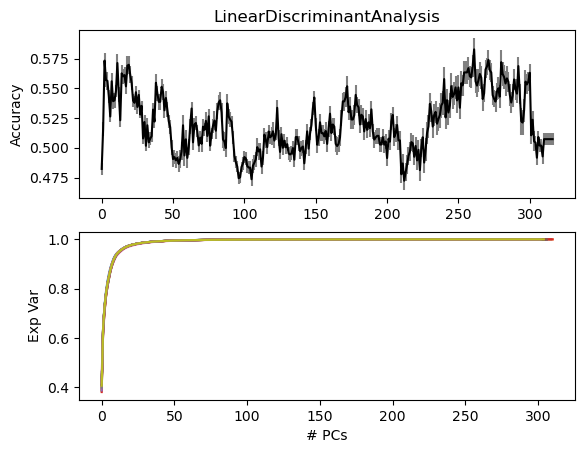

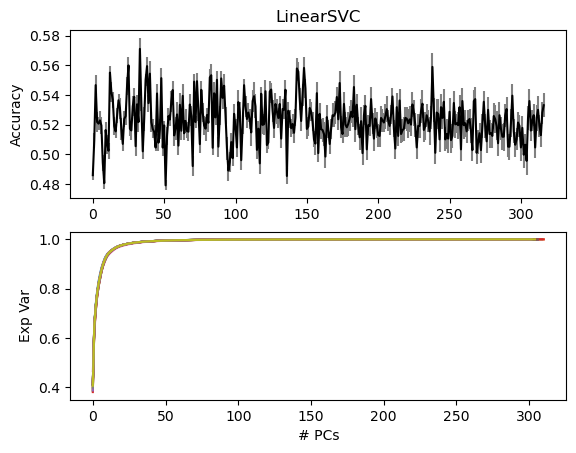

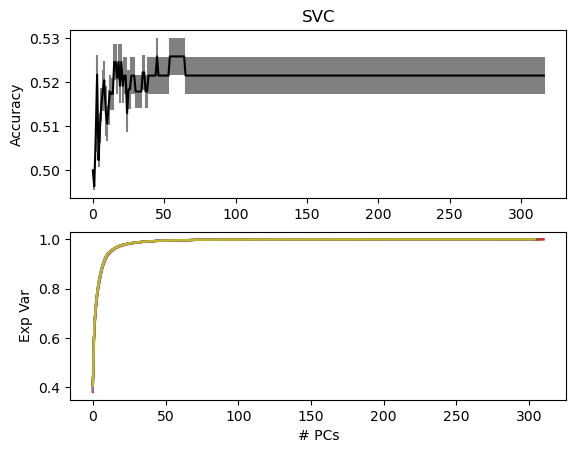

In [42]:
for n_model, model in enumerate(models):
    mdl_acc = acc_incepv3[:,n_model,:]
    mdl_means = np.nanmean(mdl_acc, axis=0)
    mdl_stderr = np.nanstd(mdl_acc, axis=0) / np.sqrt(len(mdl_means))
    
    plt.subplot(2,1,1)
    plt.errorbar(np.arange(len(mdl_means)), mdl_means, yerr=mdl_stderr, color='k', ecolor="grey")
    plt.title(f"{str(model.func).split('.')[-1][:-2]}")
    plt.ylabel("Accuracy")
    
    plt.subplot(2,1,2)
    plt.plot(np.cumsum(evs_incepv3[:,n_model,:], axis=-1).T)
    plt.xlabel("# PCs")
    plt.ylabel("Exp Var")
    plt.show()

#### Strawman: Random Initialization

In [43]:
dataset = mahnob.MahnobDataset(
    x_params={
        "feature": "TopomapNN",
        "model": "inception_v3",
        "model_params": {
            "weights": "DEFAULT",
        },
        "model_augment_fn": inception_augment,
        "random_weights": {
            "mode": "rand_init"
        },
        "window": -1,
        "stride": -1
    },
    sessions=None,
    y_mode='bimodal',
    y_keys=['feltVlnc'],
    seed=49,
    balanced=False,
)

100%|██████████| 526/526 [01:20<00:00,  6.50it/s]

INFO: T dimension is not equivalent across all S; reducing to T=1


In [44]:
acc_incepv3_randinit, evs_incepv3_randinit, train_acc_incepv3_randinit = subject_cv(dataset, subjects, reduced_models, sweep_pc=True)

 14%|█▍        | 4/29 [00:38<04:02,  9.71s/it]

Skipping: fewer than 3 samples per class detected
Skipping: Y train or Y test having no values


 28%|██▊       | 8/29 [00:58<02:17,  6.56s/it]

Skipping: Y train or Y test having no values
Skipping: num classes not being equivalent in train and test
Skipping: fewer than 3 samples per class detected


 76%|███████▌  | 22/29 [02:44<01:05,  9.32s/it]

Skipping: fewer than 3 samples per class detected


100%|██████████| 29/29 [03:42<00:00,  7.68s/it]


In [45]:
with open("result_incepv3_straw_randinit.pkl", "wb") as fout:
    pickle.dump({"acc": acc_incepv3_randinit,
                 "train_acc": train_acc_incepv3_randinit,
                 "ev": evs_incepv3_randinit, "models": reduced_models}, fout)

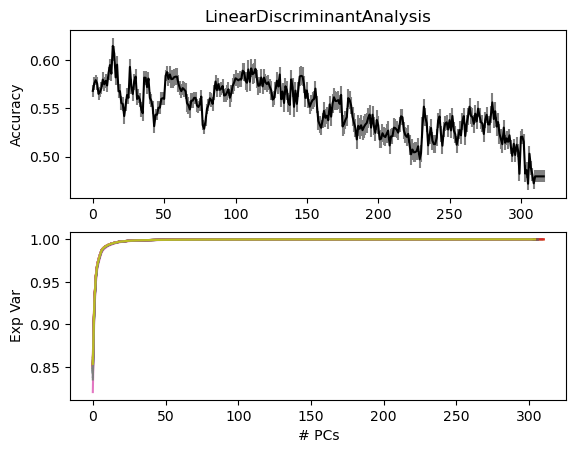

In [46]:
for n_model, model in enumerate(reduced_models):
    mdl_acc = acc_incepv3_randinit[:,n_model,:]
    mdl_means = np.nanmean(mdl_acc, axis=0)
    mdl_stderr = np.nanstd(mdl_acc, axis=0) / np.sqrt(len(mdl_means))
    
    plt.subplot(2,1,1)
    plt.errorbar(np.arange(len(mdl_means)), mdl_means, yerr=mdl_stderr, color='k', ecolor="grey")
    plt.title(f"{str(model.func).split('.')[-1][:-2]}")
    plt.ylabel("Accuracy")
    
    plt.subplot(2,1,2)
    plt.plot(np.cumsum(evs_incepv3_randinit[:,n_model,:], axis=-1).T)
    plt.xlabel("# PCs")
    plt.ylabel("Exp Var")
    plt.show()

## Random Projections
Here we explore whether deep feature transformers operate differently than high-dimensional random projections.

In [48]:
dataset = mahnob.MahnobDataset(
    x_params={
        "feature": "TopomapImg", 
        "window": -1,
        "stride": -1
    },
    sessions=None,
    y_mode='bimodal',
    y_keys=['feltVlnc'],
    seed=49,
    balanced=False,
)

100%|██████████| 526/526 [01:11<00:00,  7.31it/s]

INFO: T dimension is not equivalent across all S; reducing to T=1


In [50]:
acc_rp, rp_list, train_acc_rp = subject_cv_rp(dataset, subjects, reduced_models, n_rp_list=list(range(1,4097,100)))

 14%|█▍        | 4/29 [02:27<15:19, 36.79s/it]

Skipping: fewer than 3 samples per class detected
Skipping: Y train or Y test having no values



 38%|███▊      | 11/29 [03:40<03:45, 12.52s/it]

Skipping: Y train or Y test having no values
Skipping: num classes not being equivalent in train and test
Skipping: fewer than 3 samples per class detected


 76%|███████▌  | 22/29 [10:23<04:09, 35.66s/it]

Skipping: fewer than 3 samples per class detected



100%|██████████| 29/29 [14:02<00:00, 29.06s/it]


In [51]:
with open("result_rp.pkl", "wb") as fout:
    pickle.dump({"acc": acc_rp,
                 "train_acc": train_acc_rp,
                 "rp": rp_list, "models": reduced_models}, fout)

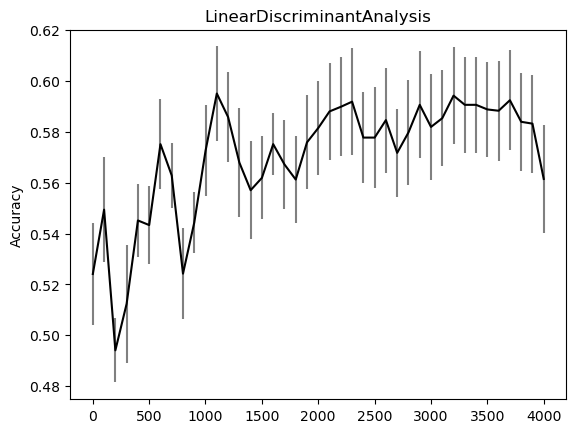

In [52]:
for n_model, model in enumerate(reduced_models):
    mdl_acc = acc_rp[:,n_model,:]
    mdl_means = np.nanmean(mdl_acc, axis=0)
    mdl_stderr = np.nanstd(mdl_acc, axis=0) / np.sqrt(len(mdl_means))
    
    plt.errorbar(rp_list, mdl_means, yerr=mdl_stderr, color='k', ecolor="grey")
    plt.title(f"{str(model.func).split('.')[-1][:-2]}")
    plt.ylabel("Accuracy")

    plt.show()

### PCA(RP_4096(Topo))

In [54]:
acc_rp_pc, ev_rp_pc, train_acc_rp_pc = subject_cv_rp_pc(dataset, subjects, reduced_models, sweep_pc=True, nrp=4096)

  0%|          | 0/29 [00:00<?, ?it/s]
0it [00:00, ?it/s]
29it [00:00, 283.16it/s]
58it [00:00, 167.92it/s]
78it [00:00, 118.86it/s]
93it [00:00, 97.35it/s] 
105it [00:01, 83.37it/s]
115it [00:01, 72.64it/s]
123it [00:01, 65.40it/s]
130it [00:01, 61.99it/s]
137it [00:01, 55.80it/s]
143it [00:01, 52.60it/s]
149it [00:01, 48.03it/s]
154it [00:02, 46.00it/s]
159it [00:02, 43.41it/s]
164it [00:02, 40.08it/s]
168it [00:02, 39.20it/s]
172it [00:02, 37.96it/s]
176it [00:02, 37.25it/s]
180it [00:02, 33.78it/s]
184it [00:03, 33.45it/s]
188it [00:03, 29.76it/s]
192it [00:03, 29.89it/s]
196it [00:03, 30.20it/s]
200it [00:03, 29.29it/s]
203it [00:03, 29.42it/s]
206it [00:03, 28.40it/s]
209it [00:03, 28.15it/s]
212it [00:04, 28.30it/s]
215it [00:04, 28.36it/s]
218it [00:04, 27.85it/s]
221it [00:04, 27.35it/s]
224it [00:04, 27.91it/s]
227it [00:04, 25.74it/s]
230it [00:04, 25.36it/s]
233it [00:04, 25.63it/s]
236it [00:04, 25.22it/s]
239it [00:05, 23.88it/s]
242it [00:05, 23.31it/s]
245it [00:05, 23.

Skipping: fewer than 3 samples per class detected
Skipping: Y train or Y test having no values



0it [00:00, ?it/s]
33it [00:00, 321.87it/s]
66it [00:00, 144.70it/s]
86it [00:00, 106.70it/s]
100it [00:00, 89.62it/s]
111it [00:01, 77.91it/s]
120it [00:01, 69.63it/s]
128it [00:01, 62.02it/s]
135it [00:01, 57.70it/s]
141it [00:01, 50.98it/s]
147it [00:02, 45.51it/s]
152it [00:02, 43.85it/s]
157it [00:02, 42.18it/s]
162it [00:02, 39.06it/s]
166it [00:02, 37.85it/s]
170it [00:02, 34.23it/s]
174it [00:02, 34.12it/s]
178it [00:02, 32.92it/s]
182it [00:03, 31.29it/s]
186it [00:03, 31.40it/s]
190it [00:03, 31.37it/s]
194it [00:03, 29.39it/s]
197it [00:03, 29.37it/s]
200it [00:03, 29.50it/s]
203it [00:03, 29.58it/s]
206it [00:03, 28.82it/s]
209it [00:04, 28.46it/s]
212it [00:04, 28.10it/s]
215it [00:04, 28.56it/s]
218it [00:04, 28.20it/s]
221it [00:04, 27.46it/s]
224it [00:04, 24.98it/s]
227it [00:04, 24.89it/s]
230it [00:04, 24.55it/s]
233it [00:05, 23.46it/s]
236it [00:05, 23.70it/s]
239it [00:05, 23.92it/s]
242it [00:05, 23.84it/s]
245it [00:05, 22.38it/s]
248it [00:05, 22.99it/s]
251it

Skipping: Y train or Y test having no values
Skipping: num classes not being equivalent in train and test
Skipping: fewer than 3 samples per class detected


 38%|███▊      | 11/29 [04:13<04:03, 13.52s/it]
0it [00:00, ?it/s]
30it [00:00, 293.84it/s]
60it [00:00, 157.14it/s]
80it [00:00, 118.41it/s]
95it [00:00, 93.81it/s] 
106it [00:01, 81.88it/s]
116it [00:01, 71.89it/s]
124it [00:01, 66.28it/s]
131it [00:01, 59.54it/s]
138it [00:01, 51.51it/s]
144it [00:01, 48.15it/s]
149it [00:02, 45.15it/s]
154it [00:02, 43.36it/s]
159it [00:02, 42.00it/s]
164it [00:02, 38.01it/s]
168it [00:02, 37.24it/s]
172it [00:02, 34.00it/s]
176it [00:02, 33.81it/s]
180it [00:02, 33.34it/s]
184it [00:03, 32.89it/s]
188it [00:03, 31.07it/s]
192it [00:03, 30.99it/s]
196it [00:03, 29.68it/s]
199it [00:03, 28.84it/s]
202it [00:03, 28.56it/s]
205it [00:03, 28.33it/s]
208it [00:03, 28.09it/s]
211it [00:04, 28.18it/s]
214it [00:04, 27.57it/s]
217it [00:04, 27.29it/s]
220it [00:04, 26.05it/s]
223it [00:04, 26.34it/s]
226it [00:04, 25.90it/s]
229it [00:04, 25.58it/s]
232it [00:04, 25.23it/s]
235it [00:05, 23.83it/s]
238it [00:05, 23.73it/s]
241it [00:05, 21.58it/s]
244it [0

Skipping: fewer than 3 samples per class detected



0it [00:00, ?it/s]
29it [00:00, 287.88it/s]
58it [00:00, 167.80it/s]
78it [00:00, 117.51it/s]
93it [00:00, 96.53it/s] 
105it [00:01, 82.20it/s]
115it [00:01, 73.15it/s]
123it [00:01, 64.45it/s]
130it [00:01, 56.86it/s]
136it [00:01, 53.47it/s]
142it [00:01, 48.49it/s]
147it [00:02, 46.26it/s]
152it [00:02, 44.85it/s]
157it [00:02, 41.29it/s]
162it [00:02, 40.40it/s]
166it [00:02, 38.78it/s]
170it [00:02, 37.30it/s]
174it [00:02, 35.13it/s]
178it [00:02, 34.42it/s]
182it [00:03, 33.86it/s]
186it [00:03, 33.62it/s]
190it [00:03, 31.86it/s]
194it [00:03, 31.16it/s]
198it [00:03, 28.47it/s]
201it [00:03, 28.30it/s]
204it [00:03, 28.07it/s]
207it [00:03, 27.92it/s]
210it [00:04, 28.12it/s]
213it [00:04, 27.46it/s]
216it [00:04, 27.14it/s]
219it [00:04, 25.86it/s]
222it [00:04, 26.31it/s]
225it [00:04, 25.90it/s]
228it [00:04, 25.97it/s]
231it [00:04, 25.51it/s]
234it [00:04, 24.01it/s]
237it [00:05, 24.09it/s]
240it [00:05, 24.14it/s]
243it [00:05, 22.54it/s]
246it [00:05, 22.74it/s]
249it

In [55]:
with open("result_rp_pc.pkl", "wb") as fout:
    pickle.dump({"acc": acc_rp_pc, 
                 "train_acc": train_acc_rp_pc, 
                 "ev": ev_rp_pc, "models": reduced_models}, fout)

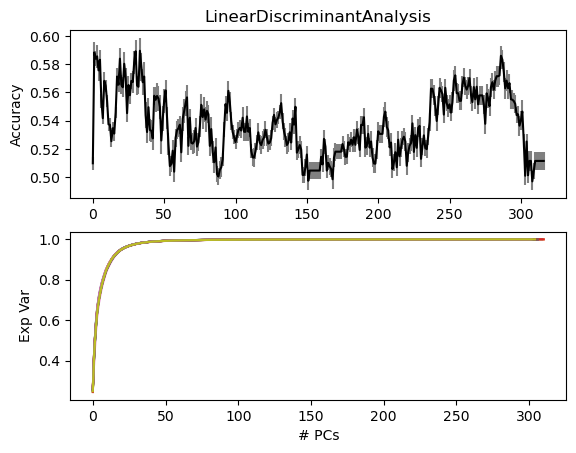

In [56]:
for n_model, model in enumerate(reduced_models):
    mdl_acc = acc_rp_pc[:,n_model,:]
    mdl_means = np.nanmean(mdl_acc, axis=0)
    mdl_stderr = np.nanstd(mdl_acc, axis=0) / np.sqrt(len(mdl_means))
    
    plt.subplot(2,1,1)
    plt.errorbar(np.arange(len(mdl_means)), mdl_means, yerr=mdl_stderr, color='k', ecolor="grey")
    plt.title(f"{str(model.func).split('.')[-1][:-2]}")
    plt.ylabel("Accuracy")
    
    plt.subplot(2,1,2)
    plt.plot(np.cumsum(ev_rp_pc[:,n_model,:], axis=-1).T)
    plt.xlabel("# PCs")
    plt.ylabel("Exp Var")
    plt.show()

### Strawman: PCA(Topo) without RP

In [57]:
acc_topo, ev_topo, train_acc_topo = subject_cv(dataset, subjects, reduced_models, sweep_pc=True)

 14%|█▍        | 4/29 [01:41<10:32, 25.30s/it]

Skipping: fewer than 3 samples per class detected
Skipping: Y train or Y test having no values


 38%|███▊      | 11/29 [02:31<02:34,  8.61s/it]

Skipping: Y train or Y test having no values
Skipping: num classes not being equivalent in train and test
Skipping: fewer than 3 samples per class detected


 76%|███████▌  | 22/29 [07:05<02:49, 24.22s/it]

Skipping: fewer than 3 samples per class detected


100%|██████████| 29/29 [09:35<00:00, 19.84s/it]


In [58]:
with open("result_topo.pkl", "wb") as fout:
    pickle.dump({"acc": acc_topo,
                 "train_acc": train_acc_topo,
                 "ev": ev_topo, "models": reduced_models}, fout)

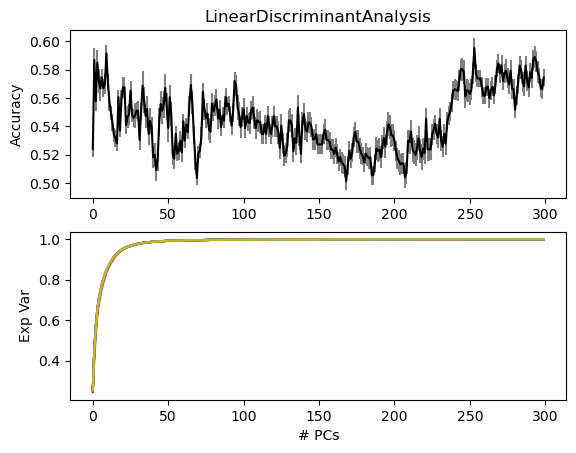

In [59]:
for n_model, model in enumerate(reduced_models):
    mdl_acc = acc_topo[:,n_model,:]
    mdl_means = np.nanmean(mdl_acc, axis=0)
    mdl_stderr = np.nanstd(mdl_acc, axis=0) / np.sqrt(len(mdl_means))
    
    plt.subplot(2,1,1)
    plt.errorbar(np.arange(len(mdl_means)), mdl_means, yerr=mdl_stderr, color='k', ecolor="grey")
    plt.title(f"{str(model.func).split('.')[-1][:-2]}")
    plt.ylabel("Accuracy")
    
    plt.subplot(2,1,2)
    plt.plot(np.cumsum(ev_topo[:,n_model,:], axis=-1).T)
    plt.xlabel("# PCs")
    plt.ylabel("Exp Var")
    plt.show()

### PCA(RP_270000(AvgPwr))

In [60]:
dataset = mahnob.MahnobDataset(
    x_params={
        "feature": "AvgFreqPower", 
        "window": -1,
        "stride": -1
    },
    sessions=None,
    y_mode='bimodal',
    y_keys=['feltVlnc'],
    seed=49,
    balanced=False,
)

100%|██████████| 526/526 [00:22<00:00, 23.16it/s]

INFO: T dimension is not equivalent across all S; reducing to T=1


In [61]:
acc_avgpwr_rp_pc, ev_avgpwr_rp_pc, train_acc_avgpwr_rp_pc = subject_cv_rp_pc(dataset, subjects, reduced_models, sweep_pc=True, nrp=270000)

  0%|          | 0/29 [00:00<?, ?it/s]
0it [00:00, ?it/s]
29it [00:00, 285.67it/s]
58it [00:00, 171.71it/s]
78it [00:00, 125.25it/s]
93it [00:00, 98.45it/s] 
105it [00:00, 84.56it/s]
115it [00:01, 73.97it/s]
123it [00:01, 68.19it/s]
131it [00:01, 61.01it/s]
138it [00:01, 53.92it/s]
144it [00:01, 49.28it/s]
149it [00:01, 45.89it/s]
154it [00:02, 43.99it/s]
159it [00:02, 42.33it/s]
164it [00:02, 38.88it/s]
168it [00:02, 37.42it/s]
172it [00:02, 34.60it/s]
176it [00:02, 33.95it/s]
180it [00:02, 33.33it/s]
184it [00:03, 30.90it/s]
188it [00:03, 30.60it/s]
192it [00:03, 30.60it/s]
196it [00:03, 29.09it/s]
199it [00:03, 28.17it/s]
202it [00:03, 28.46it/s]
205it [00:03, 28.30it/s]
208it [00:03, 27.98it/s]
211it [00:04, 27.78it/s]
214it [00:04, 28.10it/s]
217it [00:04, 26.36it/s]
220it [00:04, 26.30it/s]
223it [00:04, 25.56it/s]
226it [00:04, 25.02it/s]
229it [00:04, 23.99it/s]
232it [00:04, 24.32it/s]
235it [00:05, 24.32it/s]
238it [00:05, 24.11it/s]
241it [00:05, 22.96it/s]
244it [00:05, 23.

Skipping: fewer than 3 samples per class detected
Skipping: Y train or Y test having no values



0it [00:00, ?it/s]
31it [00:00, 299.97it/s]
61it [00:00, 157.28it/s]
81it [00:00, 118.53it/s]
96it [00:00, 94.88it/s] 
108it [00:01, 82.99it/s]
118it [00:01, 72.64it/s]
126it [00:01, 66.88it/s]
133it [00:01, 60.21it/s]
140it [00:01, 54.45it/s]
146it [00:01, 51.29it/s]
152it [00:02, 46.86it/s]
157it [00:02, 43.64it/s]
162it [00:02, 39.97it/s]
166it [00:02, 38.19it/s]
170it [00:02, 37.10it/s]
174it [00:02, 36.04it/s]
178it [00:02, 34.66it/s]
182it [00:02, 34.07it/s]
186it [00:03, 33.34it/s]
190it [00:03, 30.93it/s]
194it [00:03, 30.78it/s]
198it [00:03, 30.69it/s]
202it [00:03, 29.71it/s]
205it [00:03, 29.75it/s]
208it [00:03, 29.14it/s]
211it [00:03, 28.45it/s]
214it [00:04, 27.08it/s]
217it [00:04, 26.86it/s]
220it [00:04, 25.46it/s]
223it [00:04, 25.63it/s]
226it [00:04, 25.54it/s]
229it [00:04, 25.11it/s]
232it [00:04, 23.87it/s]
235it [00:04, 23.97it/s]
238it [00:05, 23.64it/s]
241it [00:05, 22.49it/s]
244it [00:05, 22.74it/s]
247it [00:05, 23.34it/s]
250it [00:05, 22.21it/s]
253it

Skipping: Y train or Y test having no values
Skipping: num classes not being equivalent in train and test
Skipping: fewer than 3 samples per class detected



0it [00:00, ?it/s]
29it [00:00, 283.36it/s]
58it [00:00, 147.11it/s]
77it [00:00, 115.08it/s]
91it [00:00, 96.68it/s] 
102it [00:00, 83.70it/s]
112it [00:01, 73.91it/s]
120it [00:01, 64.84it/s]
127it [00:01, 60.01it/s]
134it [00:01, 54.28it/s]
140it [00:01, 51.21it/s]
146it [00:01, 46.15it/s]
151it [00:02, 43.93it/s]
156it [00:02, 40.41it/s]
161it [00:02, 39.38it/s]
165it [00:02, 33.24it/s]
169it [00:02, 29.32it/s]
173it [00:02, 25.73it/s]
176it [00:03, 25.82it/s]
179it [00:03, 23.77it/s]
182it [00:03, 24.96it/s]
186it [00:03, 27.01it/s]
189it [00:03, 27.72it/s]
192it [00:03, 28.28it/s]
195it [00:03, 27.58it/s]
198it [00:03, 27.73it/s]
201it [00:04, 27.69it/s]
204it [00:04, 28.20it/s]
207it [00:04, 28.33it/s]
210it [00:04, 26.54it/s]
213it [00:04, 26.63it/s]
216it [00:04, 26.52it/s]
219it [00:04, 26.50it/s]
222it [00:04, 26.25it/s]
225it [00:04, 24.79it/s]
228it [00:05, 24.93it/s]
231it [00:05, 22.82it/s]
234it [00:05, 22.43it/s]
237it [00:05, 22.86it/s]
240it [00:05, 23.02it/s]
243it

Skipping: fewer than 3 samples per class detected



0it [00:00, ?it/s]
31it [00:00, 308.76it/s]
62it [00:00, 158.23it/s]
82it [00:00, 113.01it/s]
97it [00:00, 89.65it/s] 
108it [00:01, 81.52it/s]
118it [00:01, 68.36it/s]
126it [00:01, 60.11it/s]
133it [00:01, 56.91it/s]
139it [00:01, 51.82it/s]
145it [00:01, 49.27it/s]
150it [00:02, 46.88it/s]
155it [00:02, 42.36it/s]
160it [00:02, 40.59it/s]
165it [00:02, 37.62it/s]
169it [00:02, 36.28it/s]
173it [00:02, 35.49it/s]
177it [00:02, 34.34it/s]
181it [00:03, 33.68it/s]
185it [00:03, 32.10it/s]
189it [00:03, 30.82it/s]
193it [00:03, 30.80it/s]
197it [00:03, 30.69it/s]
201it [00:03, 29.61it/s]
204it [00:03, 29.05it/s]
207it [00:03, 28.40it/s]
210it [00:04, 28.12it/s]
213it [00:04, 27.66it/s]
216it [00:04, 27.41it/s]
219it [00:04, 26.20it/s]
222it [00:04, 26.35it/s]
225it [00:04, 25.97it/s]
228it [00:04, 25.64it/s]
231it [00:04, 23.07it/s]
234it [00:05, 23.45it/s]
237it [00:05, 21.59it/s]
240it [00:05, 22.21it/s]
243it [00:05, 22.85it/s]
246it [00:05, 21.99it/s]
249it [00:05, 22.69it/s]
252it

In [62]:
with open("result_avgfreqpwr_rp_pc.pkl", "wb") as fout:
    pickle.dump({"acc": acc_avgpwr_rp_pc,
                 "train_acc": train_acc_avgpwr_rp_pc,
                 "ev": ev_avgpwr_rp_pc, "models": reduced_models}, fout)

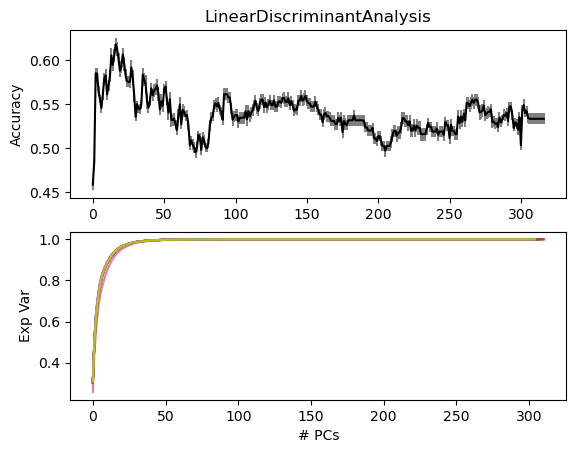

In [63]:
for n_model, model in enumerate(reduced_models):
    mdl_acc = acc_avgpwr_rp_pc[:,n_model,:]
    mdl_means = np.nanmean(mdl_acc, axis=0)
    mdl_stderr = np.nanstd(mdl_acc, axis=0) / np.sqrt(len(mdl_means))
    
    plt.subplot(2,1,1)
    plt.errorbar(np.arange(len(mdl_means)), mdl_means, yerr=mdl_stderr, color='k', ecolor="grey")
    plt.title(f"{str(model.func).split('.')[-1][:-2]}")
    plt.ylabel("Accuracy")
    
    plt.subplot(2,1,2)
    plt.plot(np.cumsum(ev_avgpwr_rp_pc[:,n_model,:], axis=-1).T)
    plt.xlabel("# PCs")
    plt.ylabel("Exp Var")
    plt.show()

### PCA(RP_270000(AvgPwrHd))

In [64]:
dataset = mahnob.MahnobDataset(
    x_params={
        "feature": "AvgFreqPowerHighDensity", 
        "window": -1,
        "stride": -1
    },
    sessions=None,
    y_mode='bimodal',
    y_keys=['feltVlnc'],
    seed=49,
    balanced=False,
)

100%|██████████| 526/526 [00:00<00:00, 844.13it/s]

INFO: T dimension is not equivalent across all S; reducing to T=1


In [65]:
acc_avgpwrhd_rp_pc, ev_avgpwrhd_rp_pc, train_acc_avgpwrhd_rp_pc = subject_cv_rp_pc(dataset, subjects, reduced_models, sweep_pc=True, nrp=270000)

  0%|          | 0/29 [00:00<?, ?it/s]
0it [00:00, ?it/s]
29it [00:00, 285.77it/s]
58it [00:00, 168.77it/s]
78it [00:00, 116.25it/s]
93it [00:00, 96.18it/s] 
105it [00:01, 83.30it/s]
115it [00:01, 73.84it/s]
123it [00:01, 64.50it/s]
130it [00:01, 60.57it/s]
137it [00:01, 55.02it/s]
143it [00:01, 49.93it/s]
148it [00:01, 47.64it/s]
153it [00:02, 45.96it/s]
158it [00:02, 42.01it/s]
163it [00:02, 39.52it/s]
167it [00:02, 35.71it/s]
171it [00:02, 35.73it/s]
175it [00:02, 35.37it/s]
179it [00:02, 34.31it/s]
183it [00:03, 33.77it/s]
187it [00:03, 30.89it/s]
191it [00:03, 29.93it/s]
195it [00:03, 28.66it/s]
198it [00:03, 28.33it/s]
201it [00:03, 28.55it/s]
204it [00:03, 28.91it/s]
207it [00:03, 28.39it/s]
210it [00:04, 28.17it/s]
213it [00:04, 27.96it/s]
216it [00:04, 26.25it/s]
219it [00:04, 25.98it/s]
222it [00:04, 25.96it/s]
225it [00:04, 26.33it/s]
228it [00:04, 25.75it/s]
231it [00:04, 24.16it/s]
234it [00:04, 24.05it/s]
237it [00:05, 24.12it/s]
240it [00:05, 23.01it/s]
243it [00:05, 23.

Skipping: fewer than 3 samples per class detected
Skipping: Y train or Y test having no values



0it [00:00, ?it/s]
30it [00:00, 295.99it/s]
60it [00:00, 168.40it/s]
80it [00:00, 118.45it/s]
95it [00:00, 98.26it/s] 
107it [00:01, 83.79it/s]
117it [00:01, 73.44it/s]
125it [00:01, 65.49it/s]
132it [00:01, 60.65it/s]
139it [00:01, 54.47it/s]
145it [00:01, 49.48it/s]
150it [00:02, 46.11it/s]
155it [00:02, 44.10it/s]
160it [00:02, 41.75it/s]
165it [00:02, 39.84it/s]
169it [00:02, 38.42it/s]
173it [00:02, 35.15it/s]
177it [00:02, 33.55it/s]
181it [00:02, 33.43it/s]
185it [00:03, 32.07it/s]
189it [00:03, 31.90it/s]
193it [00:03, 31.71it/s]
197it [00:03, 29.97it/s]
201it [00:03, 30.54it/s]
205it [00:03, 30.23it/s]
209it [00:03, 28.74it/s]
212it [00:04, 28.31it/s]
215it [00:04, 28.65it/s]
218it [00:04, 27.07it/s]
221it [00:04, 25.01it/s]
224it [00:04, 24.89it/s]
227it [00:04, 25.49it/s]
230it [00:04, 25.26it/s]
233it [00:04, 23.90it/s]
236it [00:05, 23.96it/s]
239it [00:05, 24.42it/s]
242it [00:05, 23.04it/s]
245it [00:05, 22.07it/s]
248it [00:05, 21.48it/s]
251it [00:05, 22.27it/s]
254it

Skipping: Y train or Y test having no values
Skipping: num classes not being equivalent in train and test
Skipping: fewer than 3 samples per class detected



0it [00:00, ?it/s]
29it [00:00, 283.12it/s]
58it [00:00, 166.65it/s]
78it [00:00, 118.70it/s]
93it [00:00, 94.55it/s] 
104it [00:01, 82.63it/s]
114it [00:01, 72.46it/s]
122it [00:01, 64.28it/s]
129it [00:01, 59.85it/s]
136it [00:01, 53.23it/s]
142it [00:01, 47.10it/s]
147it [00:02, 44.28it/s]
152it [00:02, 40.14it/s]
156it [00:02, 39.69it/s]
160it [00:02, 38.57it/s]
164it [00:02, 37.78it/s]
168it [00:02, 34.76it/s]
172it [00:02, 34.38it/s]
176it [00:02, 33.55it/s]
180it [00:03, 33.58it/s]
184it [00:03, 31.58it/s]
188it [00:03, 31.39it/s]
192it [00:03, 31.40it/s]
196it [00:03, 30.09it/s]
200it [00:03, 30.29it/s]
204it [00:03, 30.15it/s]
208it [00:04, 28.19it/s]
211it [00:04, 26.43it/s]
214it [00:04, 25.88it/s]
217it [00:04, 25.89it/s]
220it [00:04, 25.77it/s]
223it [00:04, 25.57it/s]
226it [00:04, 25.32it/s]
229it [00:04, 20.85it/s]
232it [00:05, 19.59it/s]
235it [00:05, 19.01it/s]
237it [00:05, 18.48it/s]
240it [00:05, 18.56it/s]
243it [00:05, 19.58it/s]
246it [00:05, 20.60it/s]
249it

Skipping: fewer than 3 samples per class detected



0it [00:00, ?it/s]
30it [00:00, 294.59it/s]
60it [00:00, 157.76it/s]
80it [00:00, 114.39it/s]
94it [00:00, 92.41it/s] 
105it [00:01, 80.97it/s]
114it [00:01, 74.31it/s]
122it [00:01, 65.89it/s]
129it [00:01, 58.29it/s]
135it [00:01, 54.86it/s]
141it [00:01, 47.95it/s]
146it [00:01, 45.95it/s]
151it [00:02, 44.33it/s]
156it [00:02, 41.94it/s]
161it [00:02, 39.30it/s]
165it [00:02, 35.84it/s]
169it [00:02, 35.14it/s]
173it [00:02, 34.96it/s]
177it [00:02, 34.78it/s]
181it [00:03, 32.58it/s]
185it [00:03, 29.04it/s]
189it [00:03, 29.38it/s]
192it [00:03, 29.42it/s]
195it [00:03, 29.52it/s]
198it [00:03, 29.64it/s]
201it [00:03, 29.69it/s]
204it [00:03, 29.65it/s]
208it [00:03, 30.20it/s]
212it [00:04, 30.07it/s]
216it [00:04, 27.81it/s]
219it [00:04, 27.73it/s]
222it [00:04, 27.04it/s]
225it [00:04, 25.75it/s]
228it [00:04, 25.38it/s]
231it [00:04, 24.80it/s]
234it [00:05, 23.17it/s]
237it [00:05, 22.20it/s]
240it [00:05, 22.62it/s]
243it [00:05, 22.26it/s]
246it [00:05, 22.32it/s]
249it

In [66]:
with open("result_avgfreqpwrhd_rp_pc.pkl", "wb") as fout:
    pickle.dump({"acc": acc_avgpwrhd_rp_pc,
                 "train_acc": train_acc_avgpwrhd_rp_pc,
                 "ev": ev_avgpwrhd_rp_pc, "models": reduced_models}, fout)

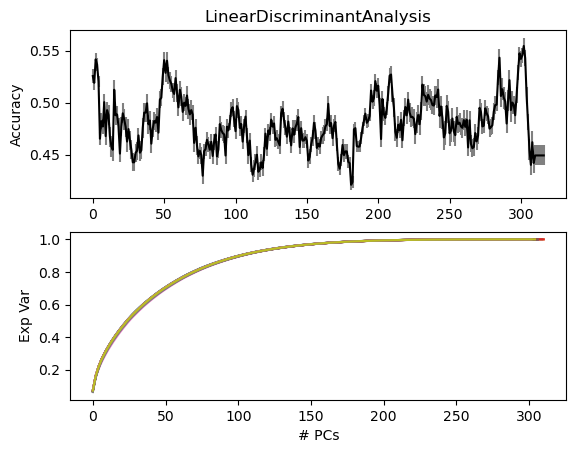

In [67]:
for n_model, model in enumerate(reduced_models):
    mdl_acc = acc_avgpwrhd_rp_pc[:,n_model,:]
    mdl_means = np.nanmean(mdl_acc, axis=0)
    mdl_stderr = np.nanstd(mdl_acc, axis=0) / np.sqrt(len(mdl_means))
    
    plt.subplot(2,1,1)
    plt.errorbar(np.arange(len(mdl_means)), mdl_means, yerr=mdl_stderr, color='k', ecolor="grey")
    plt.title(f"{str(model.func).split('.')[-1][:-2]}")
    plt.ylabel("Accuracy")
    
    plt.subplot(2,1,2)
    plt.plot(np.cumsum(ev_avgpwrhd_rp_pc[:,n_model,:], axis=-1).T)
    plt.xlabel("# PCs")
    plt.ylabel("Exp Var")
    plt.show()

# Metrics

In [68]:
import pickle
from matplotlib import pyplot as plt
import numpy as np

## Standard vs DFT
1. Are standard features comparable to deep feature transformer?

In [32]:
with open('result_avgfreqpwr.pkl', 'rb') as fin:
    d = pickle.load(fin)
    res_std = d['acc'] # ch representation of deatures
    res_train_std = d['train_acc'] # ch representation of deatures

with open('result_topo.pkl', 'rb') as fin:
    d = pickle.load(fin)
    res_topo = d['acc'] # topo representation of features
    res_train_topo = d['train_acc'] # topo representation of features

with open('result_specto_vgg16.pkl', 'rb') as fin:
    d = pickle.load(fin)
    res_specto = d['acc'] # topo representation of features
    res_train_specto = d['train_acc'] # topo representation of features

with open('result_vgg16.pkl', 'rb') as fin:
    d = pickle.load(fin)
    res_vgg16_pt = d['acc'] # pretrained
    res_train_vgg16_pt = d['train_acc'] # pretrained

In [33]:
def gen_y(aggop_subj):
    def trainmax2test(train, test):
        # hacky way to get around all nan argmax
        _train = np.nan_to_num(train[:,0,:], nan=-1.)
        _test = test[:,0,:]
        _argmax = np.argmax(_train, axis=1)
        return [_test[n, _argmax[n]] if i[_argmax[n]] >= 0 else np.nan for n,i in enumerate(_train)]
    
    y = np.array([
        trainmax2test(res_train_std, res_std),
        trainmax2test(res_train_topo, res_topo),
        trainmax2test(res_train_specto, res_specto),
        trainmax2test(res_train_vgg16_pt, res_vgg16_pt),
    ]) # 4 -> Subjects

    means = aggop_subj(y, axis=1)
    stderrs = np.nanstd(y, axis=1)/np.sqrt(np.count_nonzero(~np.isnan(y), axis=1))
    return means, stderrs
y_mean, yerr_mean  = gen_y(np.nanmean)
y_median, yerr_median  = gen_y(np.nanmedian)
x = ["AvgFreqPwr", "AvgFreqPwr Topo", "VGG16 Specto", "VGG16 Topo"]

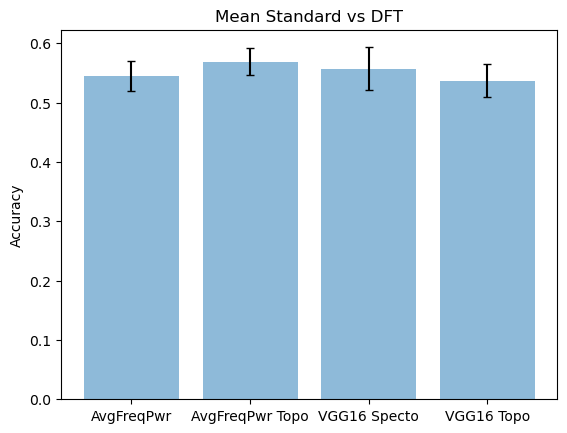

In [34]:
fig, ax = plt.subplots()
ax.bar(np.arange(len(x)), y_mean, yerr=yerr_mean, align='center', alpha=0.5, ecolor='black', capsize=3)
ax.set_xticks(np.arange(len(x)))
ax.set_xticklabels(x)
ax.set_title("Mean Standard vs DFT")
ax.set_ylabel("Accuracy")
plt.show()

## DFT architectures + Pretrained vs Random (Xe) weights
1. Are there any differences between different DFT architectures
2. Do pretrained models provide any benefit over randomly initialized architectures?

In [26]:
with open('result_vgg16.pkl', 'rb') as fin:
    d = pickle.load(fin)
    res_vgg16_pt = d['acc'] # pretrained
    res_train_vgg16_pt = d['train_acc'] # pretrained
with open('result_vgg16_straw_randinit.pkl', 'rb') as fin:
    d = pickle.load(fin)
    res_vgg16_ri = d['acc'] # rand init
    res_train_vgg16_ri = d['train_acc'] # rand init

with open('result_alexnet.pkl', 'rb') as fin:
    d = pickle.load(fin)
    res_alexnet_pt = d['acc'] # pretrained
    res_train_alexnet_pt = d['train_acc'] # pretrained
with open('result_alexnet_straw_randinit.pkl', 'rb') as fin:
    d = pickle.load(fin)
    res_alexnet_ri = d['acc'] # rand init
    res_train_alexnet_ri = d['train_acc'] # rand init

with open('result_incepv3.pkl', 'rb') as fin:
    d = pickle.load(fin)
    res_incepv3_pt = d['acc'] # pretrained
    res_train_incepv3_pt = d['train_acc'] # pretrained
with open('result_incepv3_straw_randinit.pkl', 'rb') as fin:
    d = pickle.load(fin)
    res_incepv3_ri = d['acc'] # rand init
    res_train_incepv3_ri = d['train_acc'] # rand init

In [27]:
def gen_y(aggop_subj):
    def trainmax2test(train, test):
        # hacky way to get around all nan argmax
        _train = np.nan_to_num(train[:,0,:], nan=-1.)
        _test = test[:,0,:]
        _argmax = np.argmax(_train, axis=1)
        return [_test[n, _argmax[n]] if i[_argmax[n]] >= 0 else np.nan for n,i in enumerate(_train)]
    
    y = np.array([
        trainmax2test(res_train_vgg16_pt, res_vgg16_pt),
        trainmax2test(res_train_vgg16_ri, res_vgg16_ri),
        trainmax2test(res_train_alexnet_pt, res_alexnet_pt),
        trainmax2test(res_train_alexnet_ri, res_alexnet_ri),
        trainmax2test(res_train_incepv3_pt, res_incepv3_pt),
        trainmax2test(res_train_incepv3_ri, res_incepv3_ri),
    ]) # 6 -> Subjects

    means = aggop_subj(y, axis=1)
    stderrs = np.nanstd(y, axis=1)/np.sqrt(np.count_nonzero(~np.isnan(y), axis=1))
    return means, stderrs
y_mean, yerr_mean  = gen_y(np.nanmean)
y_median, yerr_median  = gen_y(np.nanmedian)
x = ["VGG16", "VGG16 Rand", "AlexNet", "AlexNet Rand", "IncepV3", "IncepV3 Rand"]

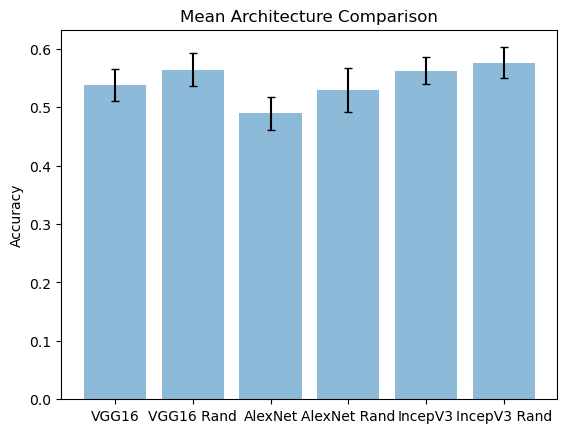

In [28]:
fig, ax = plt.subplots()
ax.bar(np.arange(len(x)), y_mean, yerr=yerr_mean, align='center', alpha=0.5, ecolor='black', capsize=3)
ax.set_xticks(np.arange(len(x)))
ax.set_xticklabels(x)
ax.set_title("Mean Architecture Comparison")
ax.set_ylabel("Accuracy")
plt.show()

## Random Projections vs DFT

In [29]:
with open('result_rp.pkl', 'rb') as fin:
    d = pickle.load(fin)
    res_rp = d['acc']
    res_train_rp = d['train_acc']

with open('result_avgfreqpwr_rp_pc.pkl', 'rb') as fin:
    d = pickle.load(fin)
    res_avgfreqpwr_rp_pc = d['acc']
    res_train_avgfreqpwr_rp_pc = d['train_acc']

with open('result_specto_rp_pc.pkl', 'rb') as fin:
    d = pickle.load(fin)
    res_specto_rp_pc = d['acc']
    res_train_specto_rp_pc = d['train_acc']

with open('result_vgg16.pkl', 'rb') as fin:
    d = pickle.load(fin)
    res_vgg16_pt = d['acc'] # pretrained
    res_train_vgg16_pt = d['train_acc'] # pretrained

In [30]:
def gen_y(aggop_subj):
    def trainmax2test(train, test):
        # hacky way to get around all nan argmax
        _train = np.nan_to_num(train[:,0,:], nan=-1.)
        _test = test[:,0,:]
        _argmax = np.argmax(_train, axis=1)
        return [_test[n, _argmax[n]] if i[_argmax[n]] >= 0 else np.nan for n,i in enumerate(_train)]
    
    y = np.array([
        trainmax2test(res_train_rp, res_rp),
        trainmax2test(res_train_avgfreqpwr_rp_pc, res_avgfreqpwr_rp_pc),
        trainmax2test(res_train_specto_rp_pc, res_specto_rp_pc),
        trainmax2test(res_train_vgg16_pt, res_vgg16_pt),
    ]) # 4 -> Subjects

    means = aggop_subj(y, axis=1)
    stderrs = np.nanstd(y, axis=1)/np.sqrt(np.count_nonzero(~np.isnan(y), axis=1))
    return means, stderrs
y_mean, yerr_mean  = gen_y(np.nanmean)
y_median, yerr_median  = gen_y(np.nanmedian)
x = ["RP(Topo)", "RP(AvgFreq)", "RP(Specto)", "VGG16(Topo)"]

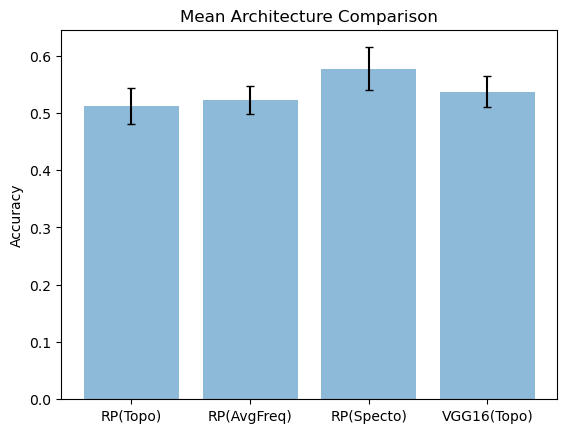

In [31]:
fig, ax = plt.subplots()
ax.bar(np.arange(len(x)), y_mean, yerr=yerr_mean, align='center', alpha=0.5, ecolor='black', capsize=3)
ax.set_xticks(np.arange(len(x)))
ax.set_xticklabels(x)
ax.set_title("Mean Architecture Comparison")
ax.set_ylabel("Accuracy")
plt.show()